In [1]:
#Import libraries you will need (along with some plot magic for notebooks)
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.stats
import pickle
import random

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
numpy.set_printoptions(precision=3,suppress=True)

## Base model

In [4]:
#Model with RGS as an explicit species
def gnaq_wt_and_mut_basal(k_G1=0.0825,k_G1_mut=0.0825,
                          k_G2=0.0,k_G2_mut=0.0,
                          k_dG1=0.0027,k_dG2=0.0027*100,
                          k_at1=0.498,k_at1_mut=0.498,k_dt1=0.3,
                          k_at2=0.498,k_at2_mut=0.498,k_dt2=0.3,
                          k_at3=0.498,k_at3_mut=0.498,k_dt3=0.3,
                          k_cat1=10.0,K_m1=500,
                          k_cat2=25.0,k_cat2_mut=25.0,
                          k_hyd2=10.0,k_hyd2_mut=10.0,
                          k_hyd=0.013,k_hyd_mut=0.013,
                          ka_gtp=1.1*10**5,kd_gtp=1.3*10**-5,ka_gdp=1.1*10**5,kd_gdp=3.5*10**-4,GTP=1.8*10**-4,GDP=1.8*10**-5,
                          RL=1.0,RGS=1.0,G_tot=200,
                          y0_in=None,
                          G0=100,Ga_GTP0=0,Ga_GDP0=0,Ga_nf0=0,Eff0=30,Ga_GTP_Eff0=0,
                          G_mut0=100,Ga_GTP_mut0=0,Ga_GDP_mut0=0,Ga_nf_mut0=0,Ga_GTP_Eff_mut0=0,
                          RGS0=40,Ga_GTP_RGS0=0,Ga_GTP_RGS_mut0=0,
                          Eff_GAP0=30,Ga_GTP_Eff_GAP0=0,Ga_GTP_Eff_GAP_mut0=0,Ga_GTP_bg0=0,Ga_GTP_bg_mut0=0,
                          t_end=1000,dt=0.1):
    def fmut(t,y):
        G = y[0]
        Ga_GTP = y[1]
        Ga_GDP = y[2]
        Ga_nf = y[3]
        Eff = y[4]
        Ga_GTP_Eff = y[5]

        G_mut = y[6]
        Ga_GTP_mut = y[7]
        Ga_GDP_mut = y[8]
        Ga_nf_mut = y[9]
        Ga_GTP_Eff_mut = y[10]
        
        Eff_GAP = y[11]
        Ga_GTP_Eff_GAP = y[12]
        Ga_GTP_Eff_GAP_mut = y[13]
        
        Ga_GTP_bg = y[14]
        Ga_GTP_bg_mut = y[15]
        
        RGS = y[16]
        Ga_GTP_RGS = y[17]
        Ga_GTP_RGS_mut = y[18]

        Gbg = G_tot-G-G_mut
        
        R0 = k_dG1*G - k_G1*Ga_GDP*Gbg
        R0_mut = k_dG1*G_mut - k_G1_mut*Ga_GDP_mut*Gbg
        R00 = k_dG2*Ga_GTP_bg - k_G2*Ga_GTP*Gbg
        R00_mut = k_dG2*Ga_GTP_bg_mut - k_G2_mut*Ga_GTP_mut*Gbg
        
        R1 = k_cat1*RL*G/(K_m1*(1+G_mut/K_m1)+G)
        R1_mut = k_cat1*RL*G_mut/(K_m1*(1+G/K_m1)+G_mut) 
        
        R2 = k_hyd*Ga_GTP
        R2_mut = k_hyd_mut*Ga_GTP_mut
        R3 = k_hyd*Ga_GTP_Eff
        R3_mut = k_hyd_mut*Ga_GTP_Eff_mut
        R4 = k_hyd*Ga_GTP_Eff_GAP
        R4_mut = k_hyd_mut*Ga_GTP_Eff_GAP_mut
        
        R5 = k_dt1*Ga_GTP_Eff_GAP - k_at1*Ga_GTP*Eff_GAP
        R5_mut = k_dt1*Ga_GTP_Eff_GAP_mut - k_at1_mut*Ga_GTP_mut*Eff_GAP
        R6 = k_dt2*Ga_GTP_Eff - k_at2*Ga_GTP*Eff
        R6_mut = k_dt2*Ga_GTP_Eff_mut - k_at2_mut*Ga_GTP_mut*Eff
        
        R7 = kd_gtp*Ga_GTP - ka_gtp*GTP*Ga_nf
        R7_mut = kd_gtp*Ga_GTP_mut - ka_gtp*GTP*Ga_nf_mut
        R8 = kd_gdp*Ga_GDP - ka_gdp*GDP*Ga_nf
        R8_mut = kd_gdp*Ga_GDP_mut - ka_gdp*GDP*Ga_nf_mut
        
#         R9 = k_cat2*RGS*Ga_GTP/(K_m2*(1+Ga_GTP_mut/K_m2_mut)+Ga_GTP)
#         R9_mut = k_cat2_mut*RGS*Ga_GTP_mut/(K_m2_mut*(1+Ga_GTP/K_m2)+Ga_GTP_mut)
        R9 = k_dt3*Ga_GTP_RGS - k_at3*Ga_GTP*RGS
        R9_mut = k_dt3*Ga_GTP_RGS_mut - k_at3_mut*Ga_GTP_mut*RGS
        R99 = k_cat2*Ga_GTP_RGS
        R99_mut = k_cat2_mut*Ga_GTP_RGS_mut
        R999 = k_hyd*Ga_GTP_RGS
        R999_mut = k_hyd_mut*Ga_GTP_RGS_mut
        
        R10 = k_hyd2*Ga_GTP_Eff_GAP
        R10_mut = k_hyd2_mut*Ga_GTP_Eff_GAP_mut
        
        res_0 =  - R0 - R1 #G
        res_1 = R1 - R2 + R5 + R6 - R7 + R00 + R9 #GaGTP
        res_2 = R0 + R2 + R3 + R4 + R10 - R8 + R99 + R999 #GaGDP
        res_3 = R7 + R8 #GaNF
        res_4 = R6 + R6_mut + R3 + R3_mut #Eff
        res_5 = - R6 - R3 #GaGTP-Eff
        
        res_6 = - R0_mut - R1_mut #G_mut
        res_7 = R1_mut - R2_mut + R5_mut + R6_mut - R7_mut + R00_mut + R9_mut #GaGTP_mut
        res_8 = R0_mut + R2_mut + R3_mut + R4_mut + R10_mut - R8_mut + R99_mut + R999_mut #GaGDP_mut
        res_9 = R7_mut + R8_mut #GaNF_mut
        res_10 = - R6_mut - R3_mut #GaGTP-Eff_mut
        
        res_11 = R5 + R5_mut + R10 + R10_mut + R4 + R4_mut #EffGAP
        res_12 = - R5 - R4 - R10 #GaGTP-EffGAP
        res_13 = - R5_mut - R4_mut - R10_mut #GaGTP-EffGAP_mut
        
        res_14 = - R00 #GaGTPbg
        res_15 = - R00_mut #GaGTPbg_mut
                                                                                   
        res_16 = R9 + R9_mut + R99 + R99_mut + R999 + R999_mut #RGS
        res_17 = - R9 - R99 - R999 #GaGTP-RGS
        res_18 = - R9_mut - R99_mut - R999_mut #GaGTP-RGS_mut

        return [res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8,res_9,res_10,
                res_11,res_12,res_13,res_14,res_15,res_16,res_17,res_18]
    
    if y0_in is None:
        y0, t0 = [G0,Ga_GTP0,Ga_GDP0,Ga_nf0,Eff0,Ga_GTP_Eff0,G_mut0,Ga_GTP_mut0,Ga_GDP_mut0,Ga_nf_mut0,Ga_GTP_Eff_mut0,Eff_GAP0,Ga_GTP_Eff_GAP0,
                 Ga_GTP_Eff_GAP_mut0,Ga_GTP_bg0,Ga_GTP_bg_mut0,RGS0,Ga_GTP_RGS0,Ga_GTP_RGS_mut0], 0
    else:
        y0, t0 = y0_in, 0
    r = scipy.integrate.ode(fmut).set_integrator('lsoda', method='bdf', with_jacobian=False)
    r.set_initial_value(y0, t0)
    
    t_vec = []
    G_vec = []
    Ga_GTP_vec = []
    Ga_GDP_vec = []
    Ga_nf_vec = []
    Eff_vec = []
    Ga_GTP_Eff_vec = []

    G_mut_vec = []
    Ga_GTP_mut_vec = []
    Ga_GDP_mut_vec = []
    Ga_nf_mut_vec = []
    Ga_GTP_Eff_mut_vec = []
    
    Eff_GAP_vec = []
    Ga_GTP_Eff_GAP_vec = []
    Ga_GTP_Eff_GAP_mut_vec = []
    
    Ga_GTP_bg_vec = []
    Ga_GTP_bg_mut_vec = []
                                                                                   
    RGS_vec = []
    Ga_GTP_RGS_vec = []
    Ga_GTP_RGS_mut_vec = []
    
    count = 1
    dmet = 1.0
    yprev = y0
    wtol = 1e-30

    while r.successful() and r.t < t_end and numpy.dot(dmet,dmet)>wtol:
        t_vec.append(r.t)
        G_vec.append(r.y[0])
        Ga_GTP_vec.append(r.y[1])
        Ga_GDP_vec.append(r.y[2])
        Ga_nf_vec.append(r.y[3])
        Eff_vec.append(r.y[4])
        Ga_GTP_Eff_vec.append(r.y[5])
        G_mut_vec.append(r.y[6])
        Ga_GTP_mut_vec.append(r.y[7])
        Ga_GDP_mut_vec.append(r.y[8])
        Ga_nf_mut_vec.append(r.y[9])
        Ga_GTP_Eff_mut_vec.append(r.y[10])
        Eff_GAP_vec.append(r.y[11])
        Ga_GTP_Eff_GAP_vec.append(r.y[12])
        Ga_GTP_Eff_GAP_mut_vec.append(r.y[13])
        Ga_GTP_bg_vec.append(r.y[14])
        Ga_GTP_bg_mut_vec.append(r.y[15])
        RGS_vec.append(r.y[16])
        Ga_GTP_RGS_vec.append(r.y[17])
        Ga_GTP_RGS_mut_vec.append(r.y[18])
        r.integrate(r.t+dt)
        dmet = r.y - yprev
        #print(numpy.dot(dmet,dmet))
        yprev = r.y
        count=count+1
        
        if r.t>=t_end:
            print('Reached the end!')
        
    return [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
            Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
            Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec]

In [5]:
#Standard heterozygous or homozygous, testing
total_g=100
g_wt_het=total_g*0.75
g_mut_het=total_g*0.25
g_wt_hom=total_g*0.5
g_mut_hom=total_g*0.5
RL_base = 0.3 #baseline: 0.3 with agonist: 0.3*6
total_eff = 10 
total_effg = 100 
khyd_plcb_wt = 10.0 

In [6]:
# Model with RGS as explicit species, standard heterozygous
#WT
params_dic_WT = {'G_tot':total_g,'G0':total_g,'G_mut0':0,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'K_m1':250.0,
                 'k_at3':0.498/6,
                 'k_hyd2':khyd_plcb_wt,
                 't_end':50000,'dt':0.1}

#Q209L (quantification of Maziarz data)
params_dic_QL = {'G_tot':total_g,'G0':g_wt_het,'G_mut0':g_mut_het,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'K_m1':250.0,
                 'k_at3':0.498/6,'k_at3_mut':0.498*1.33/6,
                 'k_hyd2':khyd_plcb_wt,
                 'k_cat2_mut':0.013/140,
                 'k_hyd2_mut':0.013/140,
                 'k_at1_mut':0.498*0.95,'k_at2_mut':0.498*1.1,'k_hyd_mut':0.013/140,
                 't_end':50000,'dt':0.1}
#Q209P (quantification of Maziarz data)
params_dic_QP = {'G_tot':total_g,'G0':g_wt_het,'G_mut0':g_mut_het,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'K_m1':250.0,
                 'k_at3':0.498/6,'k_at3_mut':0.498*0.66/6,
                 'k_hyd2':khyd_plcb_wt,
                 'k_cat2_mut':0.013/140,
                 'k_hyd2_mut':0.013/140,
                 'k_at1_mut':0.498*0.66,'k_at2_mut':0.498*0.66,'k_hyd_mut':0.013/140,
                 't_end':50000,'dt':0.1}


# Standard
#CYSLTR2
params_dic_CY = {'G_tot':total_g,'G0':total_g,'G_mut0':0,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':(RL_base/2.0)+(RL_base/2.0)*(204/15.0),'RGS0':40,
                 'K_m1':250.0,
                 'k_at3':0.498/6,
                 'k_hyd2':khyd_plcb_wt,
                 't_end':50000,'dt':0.1}

#R183C heterozygous
params_dic_RQ = {'G_tot':total_g,'G0':g_wt_het,'G_mut0':g_mut_het,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'K_m1':500/2.0,
                 'k_at3':0.498/6,'k_at3_mut':0.498/6,
                 'k_hyd2':khyd_plcb_wt,
                 'k_cat2_mut':0.013*110/140,
                 'k_hyd2_mut':0.013*7/140,
                 'k_at1_mut':0.498,'k_at2_mut':0.498,'k_hyd_mut':0.013/140,
                 't_end':50000,'dt':0.1}

In [7]:
# With agonist - to run with agonist condition, uncomment this cell and run section
# RL_base = 0.3*6
# params_dic_WT['RL'] = RL_base
# params_dic_QL['RL'] = RL_base
# params_dic_QP['RL'] = RL_base

In [8]:
# Homozygous - to run heterozygous condition, uncomment this cell and run section
# params_dic_WT['G0'] = g_wt_hom
# params_dic_QL['G0'] = g_wt_hom
# params_dic_QP['G0'] = g_wt_hom
# params_dic_RQ['G0'] = g_wt_hom

# params_dic_WT['G_mut0'] = g_mut_hom
# params_dic_QL['G_mut0'] = g_mut_hom
# params_dic_QP['G_mut0'] = g_mut_hom
# params_dic_RQ['G_mut0'] = g_mut_hom

# params_dic_CY['RL'] = RL_base*(204/15.0)

In [9]:
def check_conservation():
    #Conservation checks
    print('WT Gq:',G_vec[-1]+Ga_GTP_vec[-1]+Ga_GDP_vec[-1]+Ga_nf_vec[-1]+Ga_GTP_Eff_vec[-1]+Ga_GTP_Eff_GAP_vec[-1]+Ga_GTP_RGS_vec[-1])
    print('WT Gq:',G_vec[-1],Ga_GTP_vec[-1],Ga_GDP_vec[-1],Ga_nf_vec[-1],Ga_GTP_Eff_vec[-1],Ga_GTP_Eff_GAP_vec[-1],Ga_GTP_RGS_vec[-1])
    print('MUT Gq:',G_mut_vec[-1]+Ga_GTP_mut_vec[-1]+Ga_GDP_mut_vec[-1]+Ga_nf_mut_vec[-1]+Ga_GTP_Eff_mut_vec[-1]+Ga_GTP_Eff_GAP_mut_vec[-1]+Ga_GTP_RGS_mut_vec[-1])
    print('MUT Gq:',G_mut_vec[-1],Ga_GTP_mut_vec[-1],Ga_GDP_mut_vec[-1],Ga_nf_mut_vec[-1],Ga_GTP_Eff_mut_vec[-1],Ga_GTP_Eff_GAP_mut_vec[-1],+Ga_GTP_RGS_mut_vec[-1])
    print('Effector:',Eff_vec[-1]+Ga_GTP_Eff_vec[-1]+Ga_GTP_Eff_mut_vec[-1])
    print('Effector:',Eff_vec[-1],Ga_GTP_Eff_vec[-1],Ga_GTP_Eff_mut_vec[-1])
    print('Effector GAP:',Eff_GAP_vec[-1]+Ga_GTP_Eff_GAP_vec[-1]+Ga_GTP_Eff_GAP_mut_vec[-1])
    print('Effector GAP:',Eff_GAP_vec[-1],Ga_GTP_Eff_GAP_vec[-1],Ga_GTP_Eff_GAP_mut_vec[-1])
    print('RGS:',RGS_vec[-1]+Ga_GTP_RGS_vec[-1]+Ga_GTP_RGS_mut_vec[-1])
    print('RGS:',RGS_vec[-1],Ga_GTP_RGS_vec[-1],Ga_GTP_RGS_mut_vec[-1])

In [10]:
%%time
#WT
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_WT)

CPU times: user 109 ms, sys: 5.15 ms, total: 114 ms
Wall time: 113 ms


In [11]:
#WT
WT_active_trio_wt = Ga_GTP_Eff_vec[-1]
WT_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
WT_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
WT_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
WT_hetG_wt = G_vec[-1]
WT_hetG_mut = G_mut_vec[-1]
WT_GaGTP_wt = Ga_GTP_vec[-1]
WT_GaGTP_mut = Ga_GTP_mut_vec[-1]
WT_GaGDP_wt = Ga_GDP_vec[-1]
WT_GaGDP_mut = Ga_GDP_mut_vec[-1]

In [12]:
#Conservation checks
check_conservation()

WT Gq: 99.99999999999991
WT Gq: 96.1827435174902 0.01610956002688345 3.471341602255969 5.5793341830575665e-05 0.24990645115589916 0.07773029121925994 0.002112784509890388
MUT Gq: 0.0
MUT Gq: 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Effector: 10.000000000000002
Effector: 9.750093548844102 0.24990645115589916 0.0
Effector GAP: 100.0
Effector GAP: 99.92226970878075 0.07773029121925994 0.0
RGS: 39.99999999999993
RGS: 39.99788721549004 0.002112784509890388 0.0


In [13]:
%%time
#Q209L
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_QL)

CPU times: user 490 ms, sys: 47.5 ms, total: 537 ms
Wall time: 518 ms


In [14]:
#Q209L
QL_active_trio_wt = Ga_GTP_Eff_vec[-1]
QL_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
QL_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
QL_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
QL_hetG_wt = G_vec[-1]
QL_hetG_mut = G_mut_vec[-1]
QL_GaGTP_wt = Ga_GTP_vec[-1]
QL_GaGTP_mut = Ga_GTP_mut_vec[-1]
QL_GaGDP_wt = Ga_GDP_vec[-1]
QL_GaGDP_mut = Ga_GDP_mut_vec[-1]

In [15]:
#Conservation checks
check_conservation()

WT Gq: 75.00000000000016
WT Gq: 74.29439968293028 0.016368519685245803 0.4259809011241258 6.855193119804836e-06 0.19800749043737212 0.06320799129054391 0.0020285593394769393
MUT Gq: 25.00000000000002
MUT Gq: 0.4693509936292203 0.15843914849086788 0.002691112122431233 1.3781442484995518e-07 2.1989536660515814 19.96841923800609 2.2021457038854053
Effector: 9.999999999999998
Effector: 7.603038843511045 0.19800749043737212 2.1989536660515814
Effector GAP: 100.0
Effector GAP: 79.96837277070337 0.06320799129054391 19.96841923800609
RGS: 40.000000000000064
RGS: 37.79582573677518 0.0020285593394769393 2.2021457038854053


In [16]:
%%time
#Q209P
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_QP)

CPU times: user 367 ms, sys: 32.3 ms, total: 399 ms
Wall time: 386 ms


In [17]:
#Q209P
QP_active_trio_wt = Ga_GTP_Eff_vec[-1]
QP_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
QP_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
QP_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
QP_hetG_wt = G_vec[-1]
QP_hetG_mut = G_mut_vec[-1]
QP_GaGTP_wt = Ga_GTP_vec[-1]
QP_GaGTP_mut = Ga_GTP_mut_vec[-1]
QP_GaGDP_wt = Ga_GDP_vec[-1]
QP_GaGDP_mut = Ga_GDP_mut_vec[-1]

In [18]:
#Conservation checks
check_conservation()

WT Gq: 74.9999999999999
WT Gq: 74.28872761675564 0.01647026869226347 0.4258740059256263 6.85353606827374e-06 0.20375929834352732 0.06309151132710758 0.0020704454196894535
MUT Gq: 24.999999999999936
MUT Gq: 0.4703338583979611 0.23727285569961637 0.002696276623074921 1.849515124964711e-07 2.020679447107577 20.609015063064632 1.660002314155561
Effector: 9.999999999999988
Effector: 7.775561254548883 0.20375929834352732 2.020679447107577
Effector GAP: 100.00000000000001
Effector GAP: 79.32789342560828 0.06309151132710758 20.609015063064632
RGS: 40.00000000000003
RGS: 38.337927240424776 0.0020704454196894535 1.660002314155561


In [19]:
%%time
#CYSLTR2
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_CY)

CPU times: user 113 ms, sys: 19.9 ms, total: 133 ms
Wall time: 120 ms


In [20]:
#CYSLTR2
CY_active_trio_wt = Ga_GTP_Eff_vec[-1]
CY_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
CY_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
CY_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
CY_hetG_wt = G_vec[-1]
CY_hetG_mut = G_mut_vec[-1]
CY_GaGTP_wt = Ga_GTP_vec[-1]
CY_GaGTP_mut = Ga_GTP_mut_vec[-1]
CY_GaGDP_wt = Ga_GDP_vec[-1]
CY_GaGDP_mut = Ga_GDP_mut_vec[-1]

In [21]:
#Conservation checks
check_conservation()

WT Gq: 99.99999999999862
WT Gq: 90.26935796206952 0.11273275197442047 7.540731626340494 0.0001212452522954473 1.5208531183857597 0.541422968092782 0.014780327883339528
MUT Gq: 0.0
MUT Gq: 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Effector: 10.000000000000007
Effector: 8.479146881614248 1.5208531183857597 0.0
Effector GAP: 100.0000000000002
Effector GAP: 99.45857703190741 0.541422968092782 0.0
RGS: 39.99999999999997
RGS: 39.985219672116635 0.014780327883339528 0.0


In [22]:
%%time
#R183C
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_RQ)

CPU times: user 709 ms, sys: 38.1 ms, total: 747 ms
Wall time: 736 ms


In [23]:
#R183C
RQ_active_trio_wt = Ga_GTP_Eff_vec[-1]
RQ_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
RQ_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
RQ_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
RQ_hetG_wt = G_vec[-1]
RQ_hetG_mut = G_mut_vec[-1]
RQ_GaGTP_wt = Ga_GTP_vec[-1]
RQ_GaGTP_mut = Ga_GTP_mut_vec[-1]
RQ_GaGDP_wt = Ga_GDP_vec[-1]
RQ_GaGDP_mut = Ga_GDP_mut_vec[-1]

In [24]:
#Conservation
check_conservation()

WT Gq: 75.00000000000001
WT Gq: 74.24556518557594 0.01593118915581142 0.4715374814918536 7.587016711711359e-06 0.2022934616471093 0.06264965228929167 0.0020154428232923515
MUT Gq: 24.999999999999975
MUT Gq: 3.110952655140076 0.13718306706540223 0.019757823773853794 3.993855919509796e-07 1.8168657559262298 18.499529180458357 1.4157111182504636
Effector: 9.999999999999998
Effector: 7.980840782426659 0.2022934616471093 1.8168657559262298
Effector GAP: 99.9999999999998
Effector GAP: 81.43782116725215 0.06264965228929167 18.499529180458357
RGS: 40.000000000000014
RGS: 38.58227343892626 0.0020154428232923515 1.4157111182504636


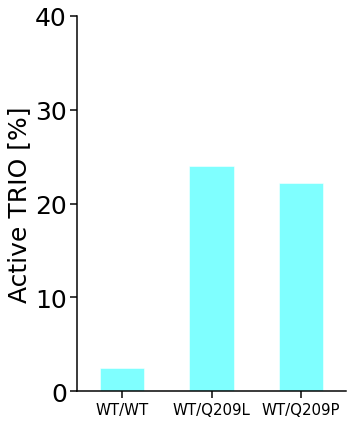

In [25]:
bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,QP_active_trio_wt])*100.0/total_eff
bars2 = numpy.array([0,QL_active_trio_mut,QP_active_trio_mut])*100.0/total_eff
# bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,CY_active_trio_wt+CY_active_trio_mut])*100.0/total_eff
# bars2 = numpy.array([0,QL_active_trio_mut,0])*100.0/total_eff
# bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,QP_active_trio_wt,CY_active_trio_wt+CY_active_trio_mut])*100.0/total_eff
# bars2 = numpy.array([0,QL_active_trio_mut,QP_active_trio_mut,0])*100.0/total_eff
bars3 = bars1 + bars2

r = [0,1,2]
# r = [0,1,2,3]

names = ['WT/WT','WT/Q209L','WT/Q209P']
# names = ['WT/WT','WT/Q209L','WT/CYSLTR2']
#names = ['WT/WT','WT/Q209L','WT/Q209P','WT/CYSLTR2']
# names = ['WT','Q209L','Q209P','CYSLTR2']
barWidth = 0.5

fig,ax = plt.subplots(figsize=(5,6))

#ax.bar(r, bars3, color='k', edgecolor='white', width=barWidth,label='WT active TRIO',alpha=1.0)
ax.bar(r, bars3, color=(0,1,1), edgecolor='white', width=barWidth,label='WT active TRIO',alpha=0.5)
# plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active TRIO',alpha=0.5)
# plt.bar(r, bars2, bottom=bars1, color=(0,1,1), edgecolor='white', width=barWidth,label='mut active TRIO',alpha=0.5)

plt.ylim([0,40])
plt.xlim([-0.5,2.5])

plt.xticks([0,1,2],[],size=15)#,fontweight='bold')

plt.xticks(r, names,size=15)#,fontweight='bold')
plt.yticks([0,10,20,30,40],size=25)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# increase tick width
ax.tick_params(length=7,width=1.5)

plt.ylabel('Active TRIO [%]',size=25)

#plt.legend(loc='upper left',fontsize=15)
plt.tight_layout()

#plt.savefig('./bound_trio_bar_chart.pdf',transparent='True')
#plt.savefig('./GNAQ_figures/bound_trio_bar_chart.svg',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_trio_bar_chart.png',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_trio_bar_chart_agonist.svg',dpi=200,transparent='True')

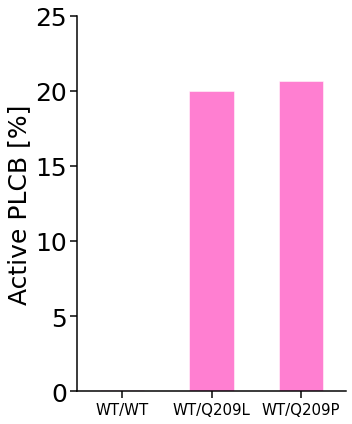

In [26]:
bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,QP_active_plcb_wt])*100.0/total_effg
bars2 = numpy.array([0,QL_active_plcb_mut,QP_active_plcb_mut])*100.0/total_effg
# bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,CY_active_plcb_wt+CY_active_plcb_mut])*100.0/total_effg
# bars2 = numpy.array([0,QL_active_plcb_mut,0])*100.0/total_effg
# bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,QP_active_plcb_wt,CY_active_plcb_wt+CY_active_plcb_mut])*100.0/total_effg
# bars2 = numpy.array([0,QL_active_plcb_mut,QP_active_plcb_mut,0])*100.0/total_effg
bars3 = bars1 + bars2

r = [0,1,2]
# r = [0,1,2,3]

names = ['WT/WT','WT/Q209L','WT/Q209P']
# names = ['WT/WT','WT/Q209L','WT/CYSLTR2']
#names = ['WT/WT','WT/Q209L','WT/Q209P','WT/CYSLTR2']
# names = ['WT','Q209L','Q209P','CYSLTR2']
barWidth = 0.5

fig,ax = plt.subplots(figsize=(5,6))

#ax.bar(r, bars3, color='k', edgecolor='white', width=barWidth,label='WT active PLCB',alpha=1.0)
ax.bar(r, bars3, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='WT active PLCB',alpha=0.5)
# plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active PLCB',alpha=0.5)
# plt.bar(r, bars2, bottom=bars1, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='mut active PLCB',alpha=0.5)

plt.ylim([0,25])
plt.xlim([-0.5,2.5])

plt.xticks([0,1,2],[],size=15)#,fontweight='bold')
plt.xticks(r, names,size=15)
plt.yticks([0,5,10,15,20,25],size=25)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# increase tick width
ax.tick_params(length=7,width=1.5)

plt.ylabel('Active PLCB [%]',size=25)

#plt.legend(loc='upper left',fontsize=15)
plt.tight_layout()

#plt.savefig('./bound_plcb_bar_chart.pdf',transparent='True')
#plt.savefig('./GNAQ_figures/bound_plcb_bar_chart.pdf',transparent='True')
#plt.savefig('./GNAQ_figures/bound_plcb_bar_chart.svg',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_plcb_bar_chart.png',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_plcb_bar_chart_agonist.svg',dpi=200,transparent='True')

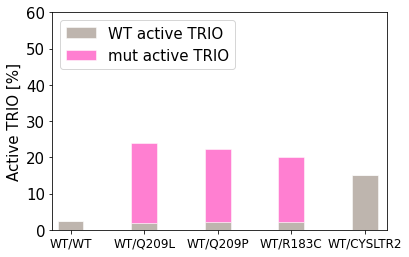

In [27]:
bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,QP_active_trio_wt,RQ_active_trio_wt,CY_active_trio_wt+CY_active_trio_mut])*100.0/total_eff
bars2 = numpy.array([0,QL_active_trio_mut,QP_active_trio_mut,RQ_active_trio_mut,0])*100.0/total_eff

r = [0,1,2,3,4]

names = ['WT/WT','WT/Q209L','WT/Q209P','WT/R183C','WT/CYSLTR2']
#names = ['WT','Q209L','Q209P','R183C','CYSLTR2']
barWidth = 0.35

plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active TRIO',alpha=0.5)
plt.bar(r, bars2, bottom=bars1, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='mut active TRIO',alpha=0.5)

plt.ylim([0,60])
plt.xlim([-0.25,4.3])

plt.xticks(r, names,size=12)#,fontweight='bold')
plt.yticks([0,10,20,30,40,50,60],size=15)

plt.ylabel('Active TRIO [%]',size=15)

plt.legend(loc='upper left',fontsize=15)

#plt.savefig('./bound_trio_bar_chart.pdf',transparent='True')

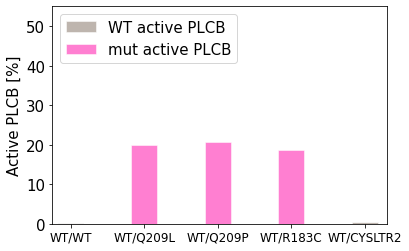

In [28]:
bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,QP_active_plcb_wt,RQ_active_plcb_wt,CY_active_plcb_wt+CY_active_plcb_mut])*100.0/total_effg
bars2 = numpy.array([0,QL_active_plcb_mut,QP_active_plcb_mut,RQ_active_plcb_mut,0])*100.0/total_effg

r = [0,1,2,3,4]

names = ['WT/WT','WT/Q209L','WT/Q209P','WT/R183C','WT/CYSLTR2']
#names = ['WT','Q209L','Q209P','R183C','CYSLTR2']
barWidth = 0.35

plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active PLCB',alpha=0.5)
plt.bar(r, bars2, bottom=bars1, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='mut active PLCB',alpha=0.5)

plt.ylim([0,55])
plt.xlim([-0.25,4.3])

plt.xticks(r, names,size=12)
plt.yticks([0,10,20,30,40,50],size=15)

plt.ylabel('Active PLCB [%]',size=15)

plt.legend(loc='upper left',fontsize=15)

#plt.savefig('./bound_plcb_bar_chart.pdf',transparent='True')

## Updated parameter set

In [29]:
# Updated parameters based on experiments and sensitivity analysis (see below)
khyd_plcb_update = 0.013*15
params_dic_WT['k_hyd2'] = khyd_plcb_update
params_dic_QL['k_hyd2'] = khyd_plcb_update
params_dic_QP['k_hyd2'] = khyd_plcb_update
params_dic_CY['k_hyd2'] = khyd_plcb_update
params_dic_RQ['k_hyd2'] = khyd_plcb_update

params_dic_QL['k_at1_mut'] = 0.498*0.5
params_dic_QL['k_at2_mut'] = 0.498*2

#WT
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_WT)

#WT
WT_active_trio_wt = Ga_GTP_Eff_vec[-1]
WT_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
WT_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
WT_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
WT_hetG_wt = G_vec[-1]
WT_hetG_mut = G_mut_vec[-1]
WT_GaGTP_wt = Ga_GTP_vec[-1]
WT_GaGTP_mut = Ga_GTP_mut_vec[-1]
WT_GaGDP_wt = Ga_GDP_vec[-1]
WT_GaGDP_mut = Ga_GDP_mut_vec[-1]

#Conservation checks
check_conservation()

#Q209L
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_QL)

#Q209L
QL_active_trio_wt = Ga_GTP_Eff_vec[-1]
QL_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
QL_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
QL_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
QL_hetG_wt = G_vec[-1]
QL_hetG_mut = G_mut_vec[-1]
QL_GaGTP_wt = Ga_GTP_vec[-1]
QL_GaGTP_mut = Ga_GTP_mut_vec[-1]
QL_GaGDP_wt = Ga_GDP_vec[-1]
QL_GaGDP_mut = Ga_GDP_mut_vec[-1]

#Conservation checks
check_conservation()

#Q209P
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_QP)

#Q209P
QP_active_trio_wt = Ga_GTP_Eff_vec[-1]
QP_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
QP_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
QP_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
QP_hetG_wt = G_vec[-1]
QP_hetG_mut = G_mut_vec[-1]
QP_GaGTP_wt = Ga_GTP_vec[-1]
QP_GaGTP_mut = Ga_GTP_mut_vec[-1]
QP_GaGDP_wt = Ga_GDP_vec[-1]
QP_GaGDP_mut = Ga_GDP_mut_vec[-1]

#Conservation checks
check_conservation()

#CYSLTR2
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_CY)

#CYSLTR2
CY_active_trio_wt = Ga_GTP_Eff_vec[-1]
CY_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
CY_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
CY_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
CY_hetG_wt = G_vec[-1]
CY_hetG_mut = G_mut_vec[-1]
CY_GaGTP_wt = Ga_GTP_vec[-1]
CY_GaGTP_mut = Ga_GTP_mut_vec[-1]
CY_GaGDP_wt = Ga_GDP_vec[-1]
CY_GaGDP_mut = Ga_GDP_mut_vec[-1]

#Conservation checks
check_conservation()

#R183C
[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_RQ)

#R183C
RQ_active_trio_wt = Ga_GTP_Eff_vec[-1]
RQ_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
RQ_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
RQ_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
RQ_hetG_wt = G_vec[-1]
RQ_hetG_mut = G_mut_vec[-1]
RQ_GaGTP_wt = Ga_GTP_vec[-1]
RQ_GaGTP_mut = Ga_GTP_mut_vec[-1]
RQ_GaGDP_wt = Ga_GDP_vec[-1]
RQ_GaGDP_mut = Ga_GDP_mut_vec[-1]

#Conservation checks
check_conservation()

WT Gq: 100.00000000000001
WT Gq: 93.93398571970751 0.03535123778386183 2.1440282271325035 3.447518115645392e-05 0.5325061891757252 3.3494580941890377 0.004636056830229067
MUT Gq: 0.0
MUT Gq: 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Effector: 10.000000000000004
Effector: 9.467493810824278 0.5325061891757252 0.0
Effector GAP: 100.00000000000007
Effector GAP: 96.65054190581104 3.3494580941890377 0.0
RGS: 40.00000000000002
RGS: 39.99536394316979 0.004636056830229067 0.0
WT Gq: 75.00000000000027
WT Gq: 71.60497313807214 0.034057536557909836 0.3730940334619674 6.0158705090406355e-06 0.2887929425887908 2.69498277339607 0.004093560052887039
MUT Gq: 25.00000000000003
MUT Gq: 0.44332959636970637 0.2477131386462773 0.0023099461639356925 1.8497483745531882e-07 4.381684076580928 16.585764714993292 3.3391983422710503
Effector: 9.99999999999998
Effector: 5.329522980830261 0.2887929425887908 4.381684076580928
Effector GAP: 100.0000000000004
Effector GAP: 80.71925251161105 2.69498277339607 16.585764714993292
RGS: 3

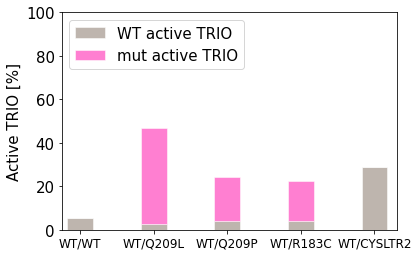

In [30]:
bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,QP_active_trio_wt,RQ_active_trio_wt,CY_active_trio_wt+CY_active_trio_mut])*100.0/total_eff
bars2 = numpy.array([0,QL_active_trio_mut,QP_active_trio_mut,RQ_active_trio_mut,0])*100.0/total_eff

r = [0,1,2,3,4]

names = ['WT/WT','WT/Q209L','WT/Q209P','WT/R183C','WT/CYSLTR2']
#names = ['WT','Q209L','Q209P','R183C','CYSLTR2']
barWidth = 0.35

plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active TRIO',alpha=0.5)
plt.bar(r, bars2, bottom=bars1, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='mut active TRIO',alpha=0.5)

plt.ylim([0,100])
plt.xlim([-0.25,4.3])

plt.xticks(r, names,size=12)#,fontweight='bold')
plt.yticks([0,20,40,60,80,100],size=15)

plt.ylabel('Active TRIO [%]',size=15)

plt.legend(loc='upper left',fontsize=15)

#plt.savefig('./GNAQ_figures/reviewer_response_12-12-23/bound_trio_bar_chart_het.svg',dpi=200,transparent='True')

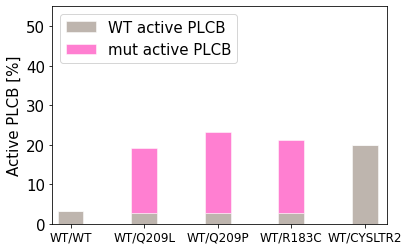

In [31]:
bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,QP_active_plcb_wt,RQ_active_plcb_wt,CY_active_plcb_wt+CY_active_plcb_mut])*100.0/total_effg
bars2 = numpy.array([0,QL_active_plcb_mut,QP_active_plcb_mut,RQ_active_plcb_mut,0])*100.0/total_effg

r = [0,1,2,3,4]

names = ['WT/WT','WT/Q209L','WT/Q209P','WT/R183C','WT/CYSLTR2']
#names = ['WT','Q209L','Q209P','R183C','CYSLTR2']
barWidth = 0.35

plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active PLCB',alpha=0.5)
plt.bar(r, bars2, bottom=bars1, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='mut active PLCB',alpha=0.5)

plt.ylim([0,55])
plt.xlim([-0.25,4.3])

plt.xticks(r, names,size=12)
plt.yticks([0,10,20,30,40,50],size=15)

plt.ylabel('Active PLCB [%]',size=15)

plt.legend(loc='upper left',fontsize=15)

#plt.savefig('./GNAQ_figures/reviewer_response_12-12-23/bound_plcb_bar_chart_het.svg',dpi=200,transparent='True')

## Sobol sensitivity analysis

In [32]:
#Reference WT
params_dic_SO = {'G_tot':total_g,'G0':g_wt_het,'G_mut0':g_mut_het,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'k_hyd2':khyd_plcb_wt,
                 'k_cat2_mut':25.0,
                 'k_hyd2_mut':khyd_plcb_wt,
                 'k_at1_mut':0.498,'k_at2_mut':0.498,'k_at3_mut':0.498/6,'k_hyd_mut':0.013,
                 't_end':100000,'dt':0.1}

In [33]:
###### NOTE: SALib is the only non-standard dependency you will likely need to install, 
######       found here: https://salib.readthedocs.io/en/latest/index.html
from SALib.sample import saltelli
from SALib.analyze import sobol

In [34]:
#Parameter ranges
problem = {
    'num_vars': 13,
    'names': ['total_g','total_RL','total_eff','total_effg','total_RGS','k_at1_base','k_at2_base','k_at3_base','khyd2','k_hyd_def','K_m1','QL_mult1','QL_mult2'],
    'bounds': [[100,200],
               [0.1,0.5],
               [10,100],
               [75,125],
               [40,100],
               [0.498/10,0.498*10],
               [0.498/10,0.498*10],
               [(0.498/6)/10,(0.498/6)*10],
               [0.013,0.013*100],
               [0.013/140,0.013/3],
               [50,500],
               [0.25,4.0],
               [0.25,4.0]]
}

In [35]:
#Example of how parameter samples are drawn
param_values = saltelli.sample(problem, 300)

/Users/michaeltrogdon/opt/anaconda3/lib/python3.8/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (300) is equal to `2^n`.
        
  warnings.warn(msg)


In [36]:
## WARNING: Next 2 cells are used to generate sensitivy analysis data, they will take several hours to run.
#             Simply uncomment the cells if you would like to generate a new sensitivity analysis, or use provided data.
#             Note: generated samples are random, so will vary from exact values used for paper

In [37]:
# YL = numpy.zeros([param_values.shape[0]])
# YL2 = numpy.zeros([param_values.shape[0]])

# YC = numpy.zeros([param_values.shape[0]])
# YC2 = numpy.zeros([param_values.shape[0]])

# Y = numpy.zeros([param_values.shape[0]])
# Y2 = numpy.zeros([param_values.shape[0]])

In [38]:
# %%time
# for i, X in enumerate(param_values):
    
#     #Q209L
#     #Standard heterozygous mutation (stored in parameter_sweep_data_1.pkl,parameter_sweep_data_2.pkl)
#     params_dic_SO['G_tot'] = X[0]
#     params_dic_SO['G0'] = X[0]*0.75
#     params_dic_SO['G_mut0'] = X[0]*0.25
    
#     params_dic_SO['RL'] = X[1]
#     params_dic_SO['Eff0'] = X[2]
#     params_dic_SO['Eff_GAP0'] = X[3]
#     params_dic_SO['RGS0'] = X[4]
    
#     params_dic_SO['K_m1'] = X[10]
    
#     params_dic_SO['k_at1'] = X[5]
#     params_dic_SO['k_at2'] = X[6]
#     params_dic_SO['k_at3'] = X[7]
#     params_dic_SO['k_hyd2'] = X[8]
    
#     params_dic_SO['k_cat2_mut'] = X[9]
#     params_dic_SO['k_hyd2_mut'] = X[9]
#     params_dic_SO['k_hyd_mut'] = X[9]
    
#     params_dic_SO['k_at1_mut'] = X[5]*X[11]
#     params_dic_SO['k_at2_mut'] = X[6]*X[12]
#     params_dic_SO['k_at3_mut'] = X[7]*1.33
    
#     [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
#      Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
#      Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_SO)
    
#     #TRIO
#     YL[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1]
#     #PLCB
#     YL2[i] = Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    
#     #CYSLTR2
#     params_dic_SO['G_tot'] = X[0]
#     params_dic_SO['G0'] = X[0]
#     params_dic_SO['G_mut0'] = 0
    
#     #Standard heteroyzygous mutation
#     params_dic_SO['RL'] = (X[1]/2) + X[1]*(204/15.0)/2 #(X[1]/2.0)+(X[1]/2.0)*6
    
#     params_dic_SO['Eff0'] = X[2]
#     params_dic_SO['Eff_GAP0'] = X[3]
#     params_dic_SO['RGS0'] = X[4]
    
#     params_dic_SO['K_m1'] = X[10]
    
#     params_dic_SO['k_at1'] = X[5]
#     params_dic_SO['k_at2'] = X[6]
#     params_dic_SO['k_at3'] = X[7]
#     params_dic_SO['k_hyd2'] = X[8]
    
#     params_dic_SO['k_cat2_mut'] = X[9]
#     params_dic_SO['k_hyd2_mut'] = X[9]
#     params_dic_SO['k_hyd_mut'] = X[9]
    
#     params_dic_SO['k_at1_mut'] = X[5]
#     params_dic_SO['k_at2_mut'] = X[6]
#     params_dic_SO['k_at3_mut'] = X[7]
    
#     [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
#      Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
#      Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_SO)
    
#     #TRIO
#     YC[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1]
#     #PLCB
#     YC2[i] = Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    
#     Y[i] = YL[i] - YC[i]
#     Y2[i] = YL2[i] - YC2[i]

# Si = sobol.analyze(problem, Y)
# Si2 = sobol.analyze(problem, Y2)
# #Si3 = sobol.analyze(problem, numpy.array(Y)+numpy.array(Y2))

In [39]:
# To generate plot with provided data, need .pkl objects in correct path
fname = './parameter_sweep_data_1.pkl'
with open(fname, 'rb') as fd:
    [problem_v3,param_values_v3,YL_v3,YL2_v3,YC_v3,YC2_v3] = pickle.load(fd, encoding='bytes')
    
fname = './parameter_sweep_data_2.pkl'
with open(fname, 'rb') as fd:
    [problem_v5,param_values_v5,YL_v5,YL2_v5,YC_v5,YC2_v5] = pickle.load(fd, encoding='bytes')

In [40]:
param_values = numpy.concatenate((param_values_v3,param_values_v5))
YL = numpy.concatenate((YL_v3,YL_v5))
YC = numpy.concatenate((YC_v3,YC_v5))
YL2 = numpy.concatenate((YL2_v3,YL2_v5))
YC2 = numpy.concatenate((YC2_v3,YC2_v5))


Y = YL - YC
Y2 = YL2 - YC2
Si = sobol.analyze(problem, Y)
Si2 = sobol.analyze(problem, Y2)

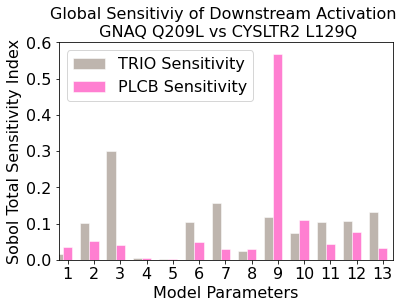

In [41]:
bars1 = [Si['ST'][0],Si['ST'][1],Si['ST'][2],Si['ST'][3],Si['ST'][4],Si['ST'][5],
         Si['ST'][6],Si['ST'][7],Si['ST'][8],Si['ST'][9],Si['ST'][10],Si['ST'][11],Si['ST'][12]]
bars2 = [Si2['ST'][0],Si2['ST'][1],Si2['ST'][2],Si2['ST'][3],Si2['ST'][4],Si2['ST'][5],
         Si2['ST'][6],Si2['ST'][7],Si2['ST'][8],Si2['ST'][9],Si2['ST'][10],Si2['ST'][11],Si2['ST'][12]]

r = [0,1,2,3,4,5,6,7,8,9,10,11,12]
r2 = [0.35,1.35,2.35,3.35,4.35,5.35,6.35,7.35,8.35,9.35,10.35,11.35,12.35]

names = ['1','2','3','4','5','6','7','8','9','10','11','12','13']
barWidth = 0.35

plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='TRIO Sensitivity',alpha=0.5)
plt.bar(r2, bars2, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='PLCB Sensitivity',alpha=0.5)

plt.ylim([0,0.6])
plt.xlim([0,12.75])

plt.xticks(r2, names,size=16)
plt.yticks(size=16)
plt.xlabel('Model Parameters',size=16)
plt.title('Global Sensitiviy of Downstream Activation \n GNAQ Q209L vs CYSLTR2 L129Q',size=16)
plt.ylabel('Sobol Total Sensitivity Index',size=16)
plt.legend(loc='upper left',fontsize=16)

#plt.savefig('./sobol_sensitivity_sweepsv3+v5.svg',transparent='True')
#plt.savefig('./GNAQ_figures/sobol_sensitivity_sweepsv3+v5.svg',dpi=200,transparent='True')

In [42]:
%%time

## Check which parameter sets match experiment and which don't
worked = []
didnt_work = []

for i, X in enumerate(param_values):
    
    if YC[i]<YL[i] and YC2[i]>=YL2[i]:
        worked.append(X)
    else:
        didnt_work.append(X)

CPU times: user 5.7 ms, sys: 183 µs, total: 5.88 ms
Wall time: 5.95 ms


In [43]:
%%time

## Check which parameter sets have certain behaviors and which don't
CY_deficient_trio = []
CY_deficient_plcb = []
CY_deficient_both = []

for i, X in enumerate(param_values):
    
    if YC[i]<YL[i] and YC2[i]>YL2[i]:
        CY_deficient_trio.append(X)
    if YC2[i]<YL2[i] and YC[i]>YL[i]:    
        CY_deficient_plcb.append(X)
    if YC[i]<YL[i] and YC2[i]<YL2[i]:
        CY_deficient_both.append(X)

CPU times: user 12.7 ms, sys: 212 µs, total: 12.9 ms
Wall time: 13.1 ms


In [44]:
print(numpy.shape(CY_deficient_trio)[0]/numpy.shape(param_values)[0])
print(numpy.shape(CY_deficient_plcb)[0]/numpy.shape(param_values)[0])
print(numpy.shape(CY_deficient_both)[0]/numpy.shape(param_values)[0])

0.04544642857142857
0.49580357142857145
0.2583035714285714


In [45]:
print(numpy.shape(worked)[0]/numpy.shape(param_values)[0])
print(numpy.shape(didnt_work)[0]/numpy.shape(param_values)[0])

0.04544642857142857
0.9545535714285714


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

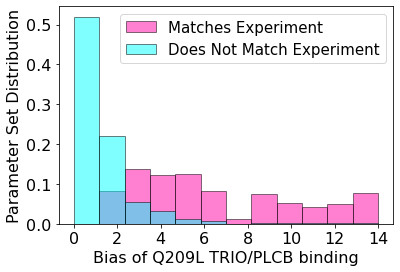

In [46]:
worked=numpy.array(worked)
didnt_work=numpy.array(didnt_work)
plt.hist(worked[:,12]/worked[:,11],color=(1,0,165/255.0),bins=12,range=[0,14],density=True,alpha=0.5,label='Matches Experiment',edgecolor='black')
plt.hist(didnt_work[:,12]/didnt_work[:,11],color=(0,1,1),bins=12,range=[0,14],density=True,alpha=0.5,label='Does Not Match Experiment',edgecolor='black')
plt.xlabel('Bias of Q209L TRIO/PLCB binding',size=16)
plt.ylabel('Parameter Set Distribution',size=16)
plt.legend(loc='upper right',fontsize=15)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.savefig('./bias_histogram_didnt_both_sweepsv3+v5.svg',transparent='True')
#plt.savefig('./GNAQ_figures/bias_histogram_didnt_both_sweepsv3+v5.svg',dpi=200,transparent='True')

([<matplotlib.axis.YTick at 0x7ff3983f94c0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

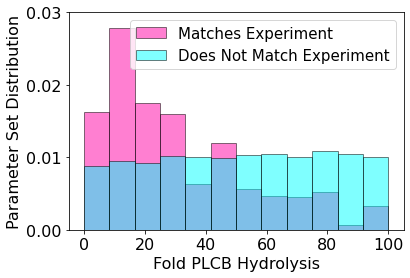

In [47]:
plt.hist(worked[:,8]/0.013,color=(1,0,165/255.0),bins=12,range=[0,100],density=True,alpha=0.5,label='Matches Experiment',edgecolor='black')
plt.hist(didnt_work[:,8]/0.013,color=(0,1,1),bins=12,range=[0,100],density=True,alpha=0.5,label='Does Not Match Experiment',edgecolor='black')
plt.xlabel('Fold PLCB Hydrolysis',size=16)
plt.ylabel('Parameter Set Distribution',size=16)
#plt.title('Behavior Matches Experiment')
plt.legend(loc='upper right',fontsize=15)
plt.xticks(size=16)
plt.yticks([0,0.01,0.02,0.03],size=16)
#plt.savefig('./khyd2_histogram_didnt_both_sweepsv3+v5.svg',dpi=200,transparent='True')
#plt.savefig('./GNAQ_figures/khyd2_histogram_didnt_both_sweepsv3+v5.svg',dpi=200,transparent='True')

KS test worked: KstestResult(statistic=0.4251547151277013, pvalue=2.1776351654193116e-80)
KS test didnt work: KstestResult(statistic=0.02024167524085685, pvalue=0.02230440992933679)


[]

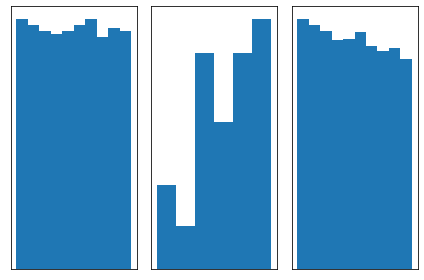

In [48]:
fig, axs = plt.subplots(1, 3,tight_layout=True)

idx = 12

print('KS test worked:', scipy.stats.ks_2samp(param_values[:,idx],worked[:,idx]))
print('KS test didnt work:',scipy.stats.ks_2samp(param_values[:,idx],didnt_work[:,idx]))

axs[0].hist(param_values[:,idx],density=True)
axs[1].hist(worked[:,idx],density=True,bins=6)
axs[2].hist(didnt_work[:,idx],density=True)

axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].set_xticks([])

axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])

In [49]:
def get_TPR_FPR_effector(YC,YL,param_values,threshold):
    
    true_positive = 0.0
    false_positive = 0.0
    false_negative = 0.0
    true_negative = 0.0

    for i, X in enumerate(param_values):
        if X[12]/X[11] >= threshold:
            if YC[i]<YL[i] and YC2[i]>=YL2[i]:
                true_positive = true_positive + 1
            else:
                false_positive = false_positive + 1
        else:
            if YC[i]<YL[i] and YC2[i]>=YL2[i]:
                false_negative = false_negative + 1
            else:
                true_negative = true_negative + 1
                
    total_positive = true_positive + false_negative
    total_negative = true_negative + false_positive
    
    #print total_positive,total_negative
    
    return [true_positive/total_positive,false_positive/total_negative]

In [50]:
def get_TPR_FPR_plcb(YC,YL,param_values,threshold):
    
    true_positive = 0.0
    false_positive = 0.0
    false_negative = 0.0
    true_negative = 0.0

    for i, X in enumerate(param_values):
        if X[8]/0.013 < threshold:
            if YC[i]<YL[i] and YC2[i]>=YL2[i]:
                true_positive = true_positive + 1
            else:
                false_positive = false_positive + 1
        else:
            if YC[i]<YL[i] and YC2[i]>=YL2[i]:
                false_negative = false_negative + 1
            else:
                true_negative = true_negative + 1
                
    total_positive = true_positive + false_negative
    total_negative = true_negative + false_positive
    
    #print total_positive,total_negative
    
    return [true_positive/total_positive,false_positive/total_negative]

In [51]:
TPR_list_effector = []
FPR_list_effector = []

for threshold in numpy.linspace(0,14,num=100):
        [TPR,FPR] = get_TPR_FPR_effector(YC,YL,param_values,threshold)
        
        TPR_list_effector.append(TPR)
        FPR_list_effector.append(FPR)

In [52]:
TPR_list_plcb = []
FPR_list_plcb = []

for threshold in numpy.linspace(0,100,num=100):
        [TPR,FPR] = get_TPR_FPR_plcb(YC,YL,param_values,threshold)
        
        TPR_list_plcb.append(TPR)
        FPR_list_plcb.append(FPR)

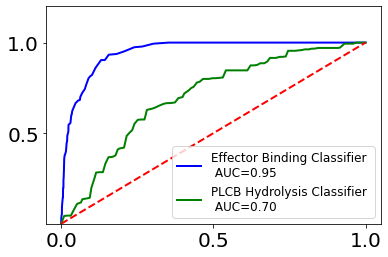

In [53]:
plt.plot(FPR_list_effector,TPR_list_effector,'b',label='Effector Binding Classifier \n AUC=0.95',linewidth=2)
plt.plot(FPR_list_plcb,TPR_list_plcb,'g',label='PLCB Hydrolysis Classifier\n AUC=0.70',linewidth=2)
plt.plot([0, 1], [0, 1], 'r--',linewidth=2)

plt.ylim([0,1.2])

plt.xticks([0,0.5,1],size=20)
plt.yticks([0.5,1],size=20)
plt.legend(loc='best',fontsize=12)

In [54]:
print(numpy.trapz(TPR_list_effector[::-1], x=FPR_list_effector[::-1]))
print(numpy.trapz(TPR_list_plcb[::-1], x=FPR_list_plcb[::-1]))

0.9486392994566607
-0.7026901793348755


In [55]:
#Testing example set of parameters 
X_post_test = [100,0.3,10,100,40,0.498,0.498,0.498/6,0.013*20,0.013/140,250,0.5,2]

In [56]:
print('total_RL:', X_post_test[1])
print('PLCB hydrolysis:', X_post_test[8]/0.013)
print('TRIO binding:',X_post_test[6],X_post_test[12])
print('PLCB binding:',X_post_test[5],X_post_test[11])

total_RL: 0.3
PLCB hydrolysis: 20.0
TRIO binding: 0.498 2
PLCB binding: 0.498 0.5


In [57]:
%%time
#VARYING PLCB HYDROLYSIS
store_vec = []
khyd2_base = 0.013*1000 #10.0
factor_list = numpy.logspace(-3,0,21)
# factor_list = numpy.logspace(-3,0,11)
for i,khyd2 in enumerate(factor_list*khyd2_base):
    #WT
    params_dic_WT['RL'] = X_post_test[1]
    params_dic_WT['G_tot'] = X_post_test[0]
    params_dic_WT['G0'] = X_post_test[0] 
    params_dic_WT['G_mut0'] = 0 
    
    params_dic_WT['Eff0'] = X_post_test[2]
    params_dic_WT['Eff_GAP0'] = X_post_test[3]
    params_dic_WT['RGS0'] = X_post_test[4]
    
    params_dic_WT['K_m1'] = X_post_test[10]
    
    params_dic_WT['k_at1'] = X_post_test[5]
    params_dic_WT['k_at2'] = X_post_test[6]
    params_dic_WT['k_at3'] = X_post_test[7]
    params_dic_WT['k_hyd2'] = khyd2

    [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
     Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
     Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_WT)

    store_vec_WT = [G_vec[-1],Ga_GTP_vec[-1],Ga_GDP_vec[-1],Ga_nf_vec[-1],Eff_vec[-1],Ga_GTP_Eff_vec[-1],G_mut_vec[-1],
                    Ga_GTP_mut_vec[-1],Ga_GDP_mut_vec[-1],Ga_nf_mut_vec[-1],Ga_GTP_Eff_mut_vec[-1],Eff_GAP_vec[-1],
                    Ga_GTP_Eff_GAP_vec[-1],Ga_GTP_Eff_GAP_mut_vec[-1],Ga_GTP_bg_vec[-1],Ga_GTP_bg_mut_vec[-1],
                    RGS_vec[-1],Ga_GTP_RGS_vec[-1],Ga_GTP_RGS_mut_vec[-1]]

    #Q209 mutants
    params_dic_QL['RL'] = X_post_test[1]
    params_dic_QL['G_tot'] = X_post_test[0] 
    params_dic_QL['G0'] = X_post_test[0]*0.75 
    params_dic_QL['G_mut0'] = X_post_test[0]*0.25 
    
    params_dic_QL['Eff0'] = X_post_test[2]
    params_dic_QL['Eff_GAP0'] = X_post_test[3]
    params_dic_QL['RGS0'] = X_post_test[4]
    
    params_dic_QL['K_m1'] = X_post_test[10]
    
    params_dic_QL['k_at1'] = X_post_test[5]
    params_dic_QL['k_at2'] = X_post_test[6]
    params_dic_QL['k_at3'] = X_post_test[7]
    params_dic_QL['k_hyd2'] = khyd2
    
    params_dic_QL['k_cat2_mut'] = X_post_test[9]
    params_dic_QL['k_hyd2_mut'] = X_post_test[9]
    params_dic_QL['k_hyd_mut'] = X_post_test[9]
    
    #Q209L
    params_dic_QL['k_at1_mut'] = X_post_test[5]*X_post_test[11]
    params_dic_QL['k_at2_mut'] = X_post_test[6]*X_post_test[12]
    params_dic_QL['k_at3_mut'] = X_post_test[7]*1.33
    
    #Q209P
#     params_dic_QL['k_at1_mut'] = X_post_test[5]*0.66
#     params_dic_QL['k_at2_mut'] = X_post_test[6]*0.66
#     params_dic_QL['k_at3_mut'] = X_post_test[7]*0.66

    [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
     Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
     Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_QL)

    store_vec_L = [G_vec[-1],Ga_GTP_vec[-1],Ga_GDP_vec[-1],Ga_nf_vec[-1],Eff_vec[-1],Ga_GTP_Eff_vec[-1],G_mut_vec[-1],
                   Ga_GTP_mut_vec[-1],Ga_GDP_mut_vec[-1],Ga_nf_mut_vec[-1],Ga_GTP_Eff_mut_vec[-1],Eff_GAP_vec[-1],
                   Ga_GTP_Eff_GAP_vec[-1],Ga_GTP_Eff_GAP_mut_vec[-1],Ga_GTP_bg_vec[-1],Ga_GTP_bg_mut_vec[-1],
                   RGS_vec[-1],Ga_GTP_RGS_vec[-1],Ga_GTP_RGS_mut_vec[-1]]
    
    #CYSLTR2
    params_dic_CY['G_tot'] = X_post_test[0] 
    params_dic_CY['G0'] = X_post_test[0] 
    params_dic_CY['G_mut0'] = 0 
    
    params_dic_CY['RL'] = (X_post_test[1]/2) + X_post_test[1]*(204/15.0)/2 
    params_dic_CY['Eff0'] = X_post_test[2]
    params_dic_CY['Eff_GAP0'] = X_post_test[3]
    params_dic_CY['RGS0'] = X_post_test[4]
    
    params_dic_CY['K_m1'] = X_post_test[10]
    
    params_dic_CY['k_at1'] = X_post_test[5]
    params_dic_CY['k_at2'] = X_post_test[6]
    params_dic_CY['k_at3'] = X_post_test[7]
    params_dic_CY['k_hyd2'] = khyd2
    
    [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
     Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
     Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_CY)

    store_vec_C = [G_vec[-1],Ga_GTP_vec[-1],Ga_GDP_vec[-1],Ga_nf_vec[-1],Eff_vec[-1],Ga_GTP_Eff_vec[-1],G_mut_vec[-1],
                   Ga_GTP_mut_vec[-1],Ga_GDP_mut_vec[-1],Ga_nf_mut_vec[-1],Ga_GTP_Eff_mut_vec[-1],Eff_GAP_vec[-1],
                   Ga_GTP_Eff_GAP_vec[-1],Ga_GTP_Eff_GAP_mut_vec[-1],Ga_GTP_bg_vec[-1],Ga_GTP_bg_mut_vec[-1],
                   RGS_vec[-1],Ga_GTP_RGS_vec[-1],Ga_GTP_RGS_mut_vec[-1]]
    
    store_vec.append([store_vec_WT,store_vec_L,store_vec_C])

CPU times: user 16.8 s, sys: 334 ms, total: 17.1 s
Wall time: 17.1 s


In [58]:
store_vec = numpy.array(store_vec)

plot_vec_YAPWT = numpy.zeros(len(factor_list))
plot_vec_YAPL = numpy.zeros(len(factor_list))
plot_vec_YAPCY = numpy.zeros(len(factor_list))

plot_vec_PLCWT = numpy.zeros(len(factor_list))
plot_vec_PLCL = numpy.zeros(len(factor_list))
plot_vec_PLCCY = numpy.zeros(len(factor_list))

plot_vec_activeGqWT = numpy.zeros(len(factor_list))
plot_vec_activeGqL = numpy.zeros(len(factor_list))
plot_vec_activeGqCY = numpy.zeros(len(factor_list))

plot_vec_testWT = numpy.zeros(len(factor_list))
plot_vec_testL = numpy.zeros(len(factor_list))
plot_vec_testCY = numpy.zeros(len(factor_list))
count = 0
for i,khyd2 in enumerate(factor_list*khyd2_base):
    plot_vec_YAPWT[i] = (store_vec[count,0,5]+store_vec[count,0,10])*100/X_post_test[2]
    plot_vec_YAPL[i] = (store_vec[count,1,5]+store_vec[count,1,10])*100/X_post_test[2]
    plot_vec_YAPCY[i] = (store_vec[count,2,5]+store_vec[count,2,10])*100/X_post_test[2]
    
    plot_vec_PLCWT[i] = (store_vec[count,0,12]+store_vec[count,0,13])*100/X_post_test[3]
    plot_vec_PLCL[i] = (store_vec[count,1,12]+store_vec[count,1,13])*100/X_post_test[3]
    plot_vec_PLCCY[i] = (store_vec[count,2,12]+store_vec[count,2,13])*100/X_post_test[3]
    
    count = count + 1

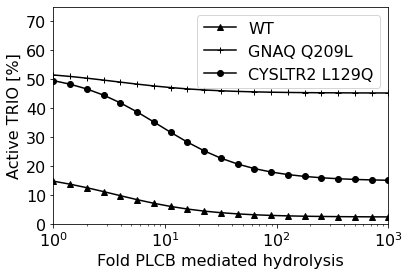

In [59]:
plot_factor = khyd2_base/0.013 #This will make the plot as fold PLCB mediated hydrolysis over basal hydrolysis
plt.semilogx(factor_list*plot_factor,plot_vec_YAPWT,'k-^',label='WT')
plt.semilogx(factor_list*plot_factor,plot_vec_YAPL,'k-+',label='GNAQ Q209L')
plt.semilogx(factor_list*plot_factor,plot_vec_YAPCY,'k-o',label='CYSLTR2 L129Q')

plt.xlim([10**0,1000.0])
plt.ylim([0,75])
plt.xlabel('Fold PLCB mediated hydrolysis',size=16)
plt.ylabel('Active TRIO [%]',size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
#plt.savefig('./khyd2_sweep_trio_X-post-test.svg',transparent='True')
#plt.savefig('./GNAQ_figures/khyd2_sweep_trio_X-post-test.svg',dpi=200,transparent='True')

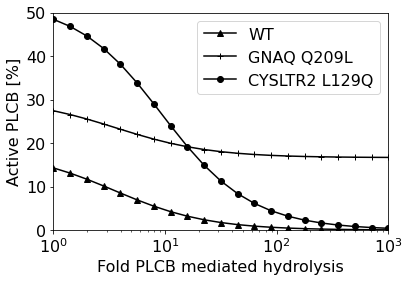

In [60]:
plot_factor = khyd2_base/0.013 #This will make the plot as fold PLCB mediated hydrolysis over basal hydrolysis
plt.semilogx(factor_list*plot_factor,plot_vec_PLCWT,'k-^',label='WT')
plt.semilogx(factor_list*plot_factor,plot_vec_PLCL,'k-+',label='GNAQ Q209L')
plt.semilogx(factor_list*plot_factor,plot_vec_PLCCY,'k-o',label='CYSLTR2 L129Q')

plt.xlim([10**0,1000.0])
plt.ylim([0,50])
plt.xlabel('Fold PLCB mediated hydrolysis',size=16)
plt.ylabel('Active PLCB [%]',size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
#plt.savefig('./khyd2_sweep_plcb_X-post-test.svg',transparent='True')
#plt.savefig('./GNAQ_figures/khyd2_sweep_plcb_X-post-test.svg',dpi=200,transparent='True')

## Parameter sets with CYSLTR2 deficient in one pathway

In [61]:
%%time

## Check which parameter sets have CYSLTR2 deficient in one pathway
thresh = 0.25
threshE = 0.1

TE_PE = 0
TE_Pup = 0
TE_Pdown = 0

Tup_PE = 0
Tup_Pup = 0
Tup_Pdown = 0

Tdown_PE = 0
Tdown_Pup = 0
Tdown_Pdown = 0

both_even = []
trio_deficient_list = []
plcb_deficient_list = []

for i, X in enumerate(param_values):
#     TRIO_avg = (YC[i]+YL[i])/2
#     PLCB_avg = (YC2[i]+YL2[i])/2
    
    TRIO_avg = max(YC[i],YL[i])
    PLCB_avg = max(YC2[i],YL2[i])
    
    if abs(YC[i]-YL[i])/TRIO_avg < threshE and abs(YC2[i]-YL2[i])/PLCB_avg < threshE:
        TE_PE = TE_PE + 1
        both_even.append(X)
    elif abs(YC[i]-YL[i])/TRIO_avg < threshE and (YC2[i]-YL2[i])/PLCB_avg > thresh:
        TE_Pup = TE_Pup + 1
    elif abs(YC[i]-YL[i])/TRIO_avg < threshE and (YL2[i]-YC2[i])/PLCB_avg > thresh:# and (YL2[i]-WT_active_plcb_wt)/PLCB_avg > thresh:
        TE_Pdown = TE_Pdown + 1
        plcb_deficient_list.append(X)
    elif (YC[i]-YL[i])/TRIO_avg > thresh and abs(YC2[i]-YL2[i])/PLCB_avg < threshE:
        Tup_PE = Tup_PE + 1
    elif (YC[i]-YL[i])/TRIO_avg > thresh and (YC2[i]-YL2[i])/PLCB_avg > thresh:
        Tup_Pup = Tup_Pup + 1
    elif (YC[i]-YL[i])/TRIO_avg > thresh and (YL2[i]-YC2[i])/PLCB_avg > thresh:
        Tup_Pdown = Tup_Pdown + 1
    elif (YL[i]-YC[i])/TRIO_avg > thresh and abs(YC2[i]-YL2[i])/PLCB_avg < threshE:# and (YL[i]-WT_active_trio_wt)/TRIO_avg > thresh:
        Tdown_PE = Tdown_PE + 1
        trio_deficient_list.append(X)
    elif (YL[i]-YC[i])/TRIO_avg > thresh and (YC2[i]-YL2[i])/PLCB_avg > thresh:
        Tdown_Pup = Tdown_Pup + 1
    elif (YL[i]-YC[i])/TRIO_avg > thresh and (YL2[i]-YC2[i])/PLCB_avg > thresh:
        Tdown_Pdown = Tdown_Pdown + 1

CPU times: user 46.9 ms, sys: 853 µs, total: 47.7 ms
Wall time: 47.2 ms


In [62]:
print(len(both_even),len(trio_deficient_list),len(plcb_deficient_list))

118 120 1139


In [63]:
#Choosing representative parameter sets for deficiency in given pathway
# X_post_test = both_even[0]
# X_post_test = plcb_deficient_list[0]
X_post_test = trio_deficient_list[0]

In [64]:
#WT
params_dic_SO['G_tot'] = X_post_test[0]
params_dic_SO['G0'] = X_post_test[0]
params_dic_SO['G_mut0'] = 0

params_dic_SO['RL'] = X_post_test[1]
params_dic_SO['Eff0'] = X_post_test[2]
params_dic_SO['Eff_GAP0'] = X_post_test[3]
params_dic_SO['RGS0'] = X_post_test[4]

params_dic_SO['K_m1'] = X_post_test[10]

params_dic_SO['k_at1'] = X_post_test[5]
params_dic_SO['k_at2'] = X_post_test[6]
params_dic_SO['k_at3'] = X_post_test[7]
params_dic_SO['k_hyd2'] = X_post_test[8]

[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_SO)

In [65]:
#WT
WT_active_trio_wt = Ga_GTP_Eff_vec[-1]
WT_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
WT_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
WT_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
WT_hetG_wt = G_vec[-1]
WT_hetG_mut = G_mut_vec[-1]
WT_GaGTP_wt = Ga_GTP_vec[-1]
WT_GaGTP_mut = Ga_GTP_mut_vec[-1]
WT_GaGDP_wt = Ga_GDP_vec[-1]
WT_GaGDP_mut = Ga_GDP_mut_vec[-1]

#Conservation checks
check_conservation()

WT Gq: 146.97265624999986
WT Gq: 139.23886530914297 0.006735922553255184 3.4050843558675457 5.47230069580732e-05 2.6919030807285202 1.6239834383811 0.006029420319533352
MUT Gq: 0.0
MUT Gq: 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Effector: 34.16992187500003
Effector: 31.47801879427151 2.6919030807285202 0.0
Effector GAP: 96.33789062500003
Effector GAP: 94.71390718661893 1.6239834383811 0.0
RGS: 41.816406249999936
RGS: 41.8103768296804 0.006029420319533352 0.0


In [66]:
#Q209L
params_dic_SO['G_tot'] = X_post_test[0]
params_dic_SO['G0'] = X_post_test[0]*0.75
params_dic_SO['G_mut0'] = X_post_test[0]*0.25

params_dic_SO['RL'] = X_post_test[1]
params_dic_SO['Eff0'] = X_post_test[2]
params_dic_SO['Eff_GAP0'] = X_post_test[3]
params_dic_SO['RGS0'] = X_post_test[4]

params_dic_SO['K_m1'] = X_post_test[10]

params_dic_SO['k_at1'] = X_post_test[5]
params_dic_SO['k_at2'] = X_post_test[6]
params_dic_SO['k_at3'] = X_post_test[7]
params_dic_SO['k_hyd2'] = X_post_test[8]

params_dic_SO['k_cat2_mut'] = X_post_test[9]
params_dic_SO['k_hyd2_mut'] = X_post_test[9]
params_dic_SO['k_hyd_mut'] = X_post_test[9]

params_dic_SO['k_at1_mut'] = X_post_test[5]*X_post_test[11]
params_dic_SO['k_at2_mut'] = X_post_test[6]*X_post_test[12]
params_dic_SO['k_at3_mut'] = X_post_test[7]*1.33

[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_SO)

In [67]:
#Conservation checks
check_conservation()

WT Gq: 110.22949218750686
WT Gq: 107.2281157116817 0.00624017598608483 0.6175421870888854 9.927497142742376e-06 0.9989965075383411 1.3734169546484774 0.005170723066249523
MUT Gq: 36.74316406250007
MUT Gq: 4.514980407091934 0.033733612528427256 0.026002423494529362 4.379883005488902e-07 20.561009525874557 8.500576102670914 3.1068615528514156
Effector: 34.16992187499996
Effector: 12.609915841587057 0.9989965075383411 20.561009525874557
Effector GAP: 96.33789062500117
Effector GAP: 86.46389756768177 1.3734169546484774 8.500576102670914
RGS: 41.816406250000036
RGS: 38.70437397408237 0.005170723066249523 3.1068615528514156


In [68]:
#Q209L
QL_active_trio_wt = Ga_GTP_Eff_vec[-1]
QL_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
QL_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
QL_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
QL_hetG_wt = G_vec[-1]
QL_hetG_mut = G_mut_vec[-1]
QL_GaGTP_wt = Ga_GTP_vec[-1]
QL_GaGTP_mut = Ga_GTP_mut_vec[-1]
QL_GaGDP_wt = Ga_GDP_vec[-1]
QL_GaGDP_mut = Ga_GDP_mut_vec[-1]

In [69]:
#CYSLTR2
params_dic_SO['G_tot'] = X_post_test[0]
params_dic_SO['G0'] = X_post_test[0]
params_dic_SO['G_mut0'] = 0

params_dic_SO['RL'] = (X_post_test[1]/2) + X_post_test[1]*(204/15.0)/2 #(X[1]/2.0)+(X[1]/2.0)*6
params_dic_SO['Eff0'] = X_post_test[2]
params_dic_SO['Eff_GAP0'] = X_post_test[3]
params_dic_SO['RGS0'] = X_post_test[4]

params_dic_SO['K_m1'] = X_post_test[10]

params_dic_SO['k_at1'] = X_post_test[5]
params_dic_SO['k_at2'] = X_post_test[6]
params_dic_SO['k_at3'] = X_post_test[7]
params_dic_SO['k_hyd2'] = X_post_test[8]

params_dic_SO['k_cat2_mut'] = X_post_test[9]
params_dic_SO['k_hyd2_mut'] = X_post_test[9]
params_dic_SO['k_hyd_mut'] = X_post_test[9]

params_dic_SO['k_at1_mut'] = X_post_test[5]
params_dic_SO['k_at2_mut'] = X_post_test[6]
params_dic_SO['k_at3_mut'] = X_post_test[7]

[t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
 Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
 Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec] = gnaq_wt_and_mut_basal(**params_dic_SO)

In [70]:
#Conservation checks
check_conservation()

WT Gq: 146.97265624999957
WT Gq: 118.01598885664745 0.04894235027080303 5.096482587120919 8.192861138869796e-05 13.095004378372568 10.67238669749863 0.04376945147778603
MUT Gq: 0.0
MUT Gq: 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Effector: 34.169921875000014
Effector: 21.07491749662745 13.095004378372568 0.0
Effector GAP: 96.33789062500236
Effector GAP: 85.66550392750372 10.67238669749863 0.0
RGS: 41.81640624999998
RGS: 41.77263679852219 0.04376945147778603 0.0


In [71]:
#CYSLTR2
CY_active_trio_wt = Ga_GTP_Eff_vec[-1]
CY_active_trio_mut =Ga_GTP_Eff_mut_vec[-1]
CY_active_plcb_wt = Ga_GTP_Eff_GAP_vec[-1]
CY_active_plcb_mut = Ga_GTP_Eff_GAP_mut_vec[-1]
CY_hetG_wt = G_vec[-1]
CY_hetG_mut = G_mut_vec[-1]
CY_GaGTP_wt = Ga_GTP_vec[-1]
CY_GaGTP_mut = Ga_GTP_mut_vec[-1]
CY_GaGDP_wt = Ga_GDP_vec[-1]
CY_GaGDP_mut = Ga_GDP_mut_vec[-1]

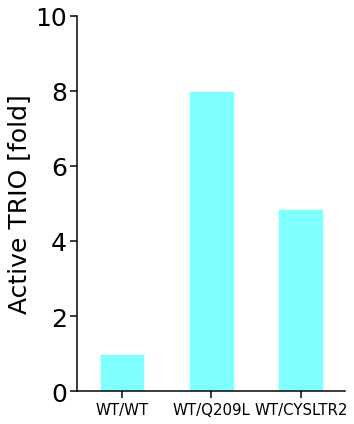

In [72]:
# bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,QP_active_trio_wt])*100.0/total_eff
# bars2 = numpy.array([0,QL_active_trio_mut,QP_active_trio_mut])*100.0/total_eff
bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,CY_active_trio_wt+CY_active_trio_mut])#*100.0/total_eff
bars2 = numpy.array([0,QL_active_trio_mut,0])#*100.0/total_eff
# bars1 = numpy.array([WT_active_trio_wt+WT_active_trio_mut,QL_active_trio_wt,QP_active_trio_wt,CY_active_trio_wt+CY_active_trio_mut])*100.0/total_eff
# bars2 = numpy.array([0,QL_active_trio_mut,QP_active_trio_mut,0])*100.0/total_eff
bars3 = (bars1 + bars2)
bars3 = bars3/bars3[0]
#bars3 = bars3*100.0/X_post_test[2]

r = [0,1,2]
# r = [0,1,2,3]

# names = ['WT/WT','WT/Q209L','WT/Q209P']
names = ['WT/WT','WT/Q209L','WT/CYSLTR2']
#names = ['WT/WT','WT/Q209L','WT/Q209P','WT/CYSLTR2']
# names = ['WT','Q209L','Q209P','CYSLTR2']
barWidth = 0.5

fig,ax = plt.subplots(figsize=(5,6))

#ax.bar(r, bars3, color='k', edgecolor='white', width=barWidth,label='WT active TRIO',alpha=1.0)
ax.bar(r, bars3, color=(0,1,1), edgecolor='white', width=barWidth,label='WT active TRIO',alpha=0.5)
# plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active TRIO',alpha=0.5)
# plt.bar(r, bars2, bottom=bars1, color=(0,1,1), edgecolor='white', width=barWidth,label='mut active TRIO',alpha=0.5)

#plt.ylim([0,45])
plt.xlim([-0.5,2.5])

plt.xticks([0,1,2],[],size=15)#,fontweight='bold')

plt.xticks(r, names,size=15)#,fontweight='bold')
plt.yticks([0,2,4,6,8,10],size=25)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# increase tick width
ax.tick_params(length=7,width=1.5)

plt.ylabel('Active TRIO [fold]',size=25)

#plt.legend(loc='upper left',fontsize=15)
plt.tight_layout()

#plt.savefig('./bound_trio_bar_chart.pdf',transparent='True')
#plt.savefig('./GNAQ_figures/bound_trio_bar_chart_trio_deficient_v2.svg',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_trio_bar_chart.png',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_trio_bar_chart_agonist.svg',dpi=200,transparent='True')

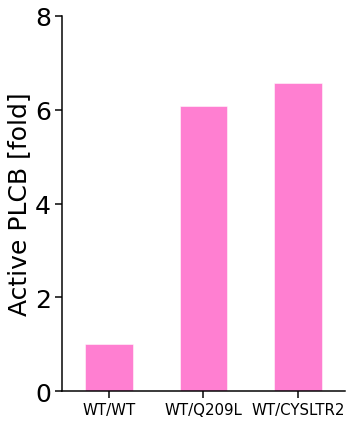

In [73]:
# bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,QP_active_plcb_wt])*100.0/total_effg
# bars2 = numpy.array([0,QL_active_plcb_mut,QP_active_plcb_mut])*100.0/total_effg
bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,CY_active_plcb_wt+CY_active_plcb_mut])#*100.0/total_effg
bars2 = numpy.array([0,QL_active_plcb_mut,0])#*100.0/total_effg
# bars1 = numpy.array([WT_active_plcb_wt+WT_active_plcb_mut,QL_active_plcb_wt,QP_active_plcb_wt,CY_active_plcb_wt+CY_active_plcb_mut])*100.0/total_effg
# bars2 = numpy.array([0,QL_active_plcb_mut,QP_active_plcb_mut,0])*100.0/total_effg
bars3 = (bars1 + bars2)
bars3 = bars3/bars3[0]
#bars3 = bars3*100.0/X_post_test[3]

r = [0,1,2]
# r = [0,1,2,3]

# names = ['WT/WT','WT/Q209L','WT/Q209P']
names = ['WT/WT','WT/Q209L','WT/CYSLTR2']
#names = ['WT/WT','WT/Q209L','WT/Q209P','WT/CYSLTR2']
# names = ['WT','Q209L','Q209P','CYSLTR2']
barWidth = 0.5

fig,ax = plt.subplots(figsize=(5,6))

#ax.bar(r, bars3, color='k', edgecolor='white', width=barWidth,label='WT active PLCB',alpha=1.0)
ax.bar(r, bars3, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='WT active PLCB',alpha=0.5)
# plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth,label='WT active PLCB',alpha=0.5)
# plt.bar(r, bars2, bottom=bars1, color=(1,0,165/255.0), edgecolor='white', width=barWidth,label='mut active PLCB',alpha=0.5)

#plt.ylim([0,3.5])
plt.xlim([-0.5,2.5])

plt.xticks([0,1,2],[],size=15)#,fontweight='bold')
plt.xticks(r, names,size=15)
plt.yticks([0,2,4,6,8],size=25)
#plt.yticks([0,10,20,30],size=25)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# increase tick width
ax.tick_params(length=7,width=1.5)

plt.ylabel('Active PLCB [fold]',size=25)

#plt.legend(loc='upper left',fontsize=15)
plt.tight_layout()

#plt.savefig('./bound_plcb_bar_chart.pdf',transparent='True')
#plt.savefig('./GNAQ_figures/bound_plcb_bar_chart.pdf',transparent='True')
#plt.savefig('./GNAQ_figures/bound_plcb_bar_chart_trio_deficient_v2.svg',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_plcb_bar_chart.png',dpi=200,transparent='True')
# plt.savefig('./GNAQ_figures/bound_plcb_bar_chart_agonist.svg',dpi=200,transparent='True')

## Model of GDI Drug

In [74]:
#Model with RGS as an explicit species
def gnaq_wt_and_mut_basal_FR(k_G1=0.0825,k_G1_mut=0.0825,
                             k_G2=0.0,k_G2_mut=0.0,
                             k_dG1=0.0027,k_dG2=0.0027*100,
                             k_at1=0.498,k_at1_mut=0.498,k_dt1=0.3,
                             k_at2=0.498,k_at2_mut=0.498,k_dt2=0.3,
                             k_at3=0.498,k_at3_mut=0.498,k_dt3=0.3,
                             k_cat1=10.0,K_m1=500,
                             k_cat2=25.0,k_cat2_mut=25.0,
                             k_hyd2=10.0,k_hyd2_mut=10.0,
                             k_hyd=0.013,k_hyd_mut=0.013,
                             k_afr=0.0825*10,k_dfr=0.0027,FR0=100,Ga_GDP_FR0=0,Ga_GDP_mut_FR0=0,G_FR0=0,G_mut_FR0=0,
                             ka_gtp=1.1*10**5,kd_gtp=1.3*10**-5,ka_gdp=1.1*10**5,kd_gdp=3.5*10**-4,GTP=1.8*10**-4,GDP=1.8*10**-5,
                             RL=1.0,RGS=1.0,G_tot=200,
                             y0_in=None,
                             G0=100,Ga_GTP0=0,Ga_GDP0=0,Ga_nf0=0,Eff0=30,Ga_GTP_Eff0=0,
                             G_mut0=100,Ga_GTP_mut0=0,Ga_GDP_mut0=0,Ga_nf_mut0=0,Ga_GTP_Eff_mut0=0,
                             RGS0=40,Ga_GTP_RGS0=0,Ga_GTP_RGS_mut0=0,
                             Eff_GAP0=30,Ga_GTP_Eff_GAP0=0,Ga_GTP_Eff_GAP_mut0=0,Ga_GTP_bg0=0,Ga_GTP_bg_mut0=0,
                             t_end=1000,dt=0.1):
    def fmut(t,y):
        G = y[0]
        Ga_GTP = y[1]
        Ga_GDP = y[2]
        Ga_nf = y[3]
        Eff = y[4]
        Ga_GTP_Eff = y[5]

        G_mut = y[6]
        Ga_GTP_mut = y[7]
        Ga_GDP_mut = y[8]
        Ga_nf_mut = y[9]
        Ga_GTP_Eff_mut = y[10]
        
        Eff_GAP = y[11]
        Ga_GTP_Eff_GAP = y[12]
        Ga_GTP_Eff_GAP_mut = y[13]
        
        Ga_GTP_bg = y[14]
        Ga_GTP_bg_mut = y[15]
        
        RGS = y[16]
        Ga_GTP_RGS = y[17]
        Ga_GTP_RGS_mut = y[18]
        
        FR = y[19]
        Ga_GDP_FR = y[20]
        Ga_GDP_mut_FR = y[21]
        G_FR = y[22]
        G_mut_FR = y[23]

        Gbg = G_tot-G-G_mut-G_FR-G_mut_FR
        
        R0 = k_dG1*G - k_G1*Ga_GDP*Gbg
        R0_mut = k_dG1*G_mut - k_G1_mut*Ga_GDP_mut*Gbg
        R00 = k_dG2*Ga_GTP_bg - k_G2*Ga_GTP*Gbg
        R00_mut = k_dG2*Ga_GTP_bg_mut - k_G2_mut*Ga_GTP_mut*Gbg
        
        R1 = k_cat1*RL*G/(K_m1*(1+G_mut/K_m1)+G)
        R1_mut = k_cat1*RL*G_mut/(K_m1*(1+G/K_m1)+G_mut) 
        
        R2 = k_hyd*Ga_GTP
        R2_mut = k_hyd_mut*Ga_GTP_mut
        R3 = k_hyd*Ga_GTP_Eff
        R3_mut = k_hyd_mut*Ga_GTP_Eff_mut
        R4 = k_hyd*Ga_GTP_Eff_GAP
        R4_mut = k_hyd_mut*Ga_GTP_Eff_GAP_mut
        
        R5 = k_dt1*Ga_GTP_Eff_GAP - k_at1*Ga_GTP*Eff_GAP
        R5_mut = k_dt1*Ga_GTP_Eff_GAP_mut - k_at1_mut*Ga_GTP_mut*Eff_GAP
        R6 = k_dt2*Ga_GTP_Eff - k_at2*Ga_GTP*Eff
        R6_mut = k_dt2*Ga_GTP_Eff_mut - k_at2_mut*Ga_GTP_mut*Eff
        
        R7 = kd_gtp*Ga_GTP - ka_gtp*GTP*Ga_nf
        R7_mut = kd_gtp*Ga_GTP_mut - ka_gtp*GTP*Ga_nf_mut
        R8 = kd_gdp*Ga_GDP - ka_gdp*GDP*Ga_nf
        R8_mut = kd_gdp*Ga_GDP_mut - ka_gdp*GDP*Ga_nf_mut
        
#         R9 = k_cat2*RGS*Ga_GTP/(K_m2*(1+Ga_GTP_mut/K_m2_mut)+Ga_GTP)
#         R9_mut = k_cat2_mut*RGS*Ga_GTP_mut/(K_m2_mut*(1+Ga_GTP/K_m2)+Ga_GTP_mut)
        R9 = k_dt3*Ga_GTP_RGS - k_at3*Ga_GTP*RGS
        R9_mut = k_dt3*Ga_GTP_RGS_mut - k_at3_mut*Ga_GTP_mut*RGS
        R99 = k_cat2*Ga_GTP_RGS
        R99_mut = k_cat2_mut*Ga_GTP_RGS_mut
        R999 = k_hyd*Ga_GTP_RGS
        R999_mut = k_hyd_mut*Ga_GTP_RGS_mut
        
        R10 = k_hyd2*Ga_GTP_Eff_GAP
        R10_mut = k_hyd2_mut*Ga_GTP_Eff_GAP_mut
        
        #Fully cell permeable
        R11 = k_dfr*Ga_GDP_FR - k_afr*FR0*Ga_GDP
        R11_mut = k_dfr*Ga_GDP_mut_FR - k_afr*FR0*Ga_GDP_mut
        R12 = k_dG1*G_FR - k_G1*Ga_GDP_FR*Gbg
        R12_mut = k_dG1*G_mut_FR - k_G1*Ga_GDP_mut_FR*Gbg
        R13 = k_dfr*G_FR - k_afr*FR0*G
        R13_mut = k_dfr*G_mut_FR - k_afr*FR0*G_mut
        
        #Zero cell permeable
#         R11 = k_dfr*Ga_GDP_FR - k_afr*FR*Ga_GDP
#         R11_mut = k_dfr*Ga_GDP_mut_FR - k_afr*FR*Ga_GDP_mut
#         R12 = k_dG1*G_FR - k_G1*Ga_GDP_FR*Gbg
#         R12_mut = k_dG1*G_mut_FR - k_G1*Ga_GDP_mut_FR*Gbg
#         R13 = k_dfr*G_FR - k_afr*FR*G
#         R13_mut = k_dfr*G_mut_FR - k_afr*FR*G_mut
        
        res_0 =  - R0 - R1 + R13 #G
        res_1 = R1 - R2 + R5 + R6 - R7 + R00 + R9 #GaGTP
        res_2 = R0 + R2 + R3 + R4 + R10 - R8 + R99 + R999 + R11 #GaGDP
        res_3 = R7 + R8 #GaNF
        res_4 = R6 + R6_mut + R3 + R3_mut #Eff
        res_5 = - R6 - R3 #GaGTP-Eff
        
        res_6 = - R0_mut - R1_mut + R13_mut #G_mut
        res_7 = R1_mut - R2_mut + R5_mut + R6_mut - R7_mut + R00_mut + R9_mut #GaGTP_mut
        res_8 = R0_mut + R2_mut + R3_mut + R4_mut + R10_mut - R8_mut + R99_mut + R999_mut + R11_mut #GaGDP_mut
        res_9 = R7_mut + R8_mut #GaNF_mut
        res_10 = - R6_mut - R3_mut #GaGTP-Eff_mut
        
        res_11 = R5 + R5_mut + R10 + R10_mut + R4 + R4_mut #EffGAP
        res_12 = - R5 - R4 - R10 #GaGTP-EffGAP
        res_13 = - R5_mut - R4_mut - R10_mut #GaGTP-EffGAP_mut
        
        res_14 = - R00 #GaGTPbg
        res_15 = - R00_mut #GaGTPbg_mut
                                                                                   
        res_16 = R9 + R9_mut + R99 + R99_mut + R999 + R999_mut #RGS
        res_17 = - R9 - R99 - R999 #GaGTP-RGS
        res_18 = - R9_mut - R99_mut - R999_mut #GaGTP-RGS_mut
        
        res_19 = R11 + R11_mut + R13 + R13_mut#FR
        res_20 = - R11 + R12 #GaGDP-FR
        res_21 = - R11_mut + R12_mut #GaGDP_mut-FR
        res_22 = - R12 - R13#G-FR
        res_23 = - R12_mut - R13_mut #G_mut-FR

        return [res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8,res_9,res_10,
                res_11,res_12,res_13,res_14,res_15,res_16,res_17,res_18,
                res_19,res_20,res_21,res_22,res_23]
    
    if y0_in is None:
        y0, t0 = [G0,Ga_GTP0,Ga_GDP0,Ga_nf0,Eff0,Ga_GTP_Eff0,G_mut0,Ga_GTP_mut0,Ga_GDP_mut0,Ga_nf_mut0,Ga_GTP_Eff_mut0,Eff_GAP0,Ga_GTP_Eff_GAP0,
                 Ga_GTP_Eff_GAP_mut0,Ga_GTP_bg0,Ga_GTP_bg_mut0,RGS0,Ga_GTP_RGS0,Ga_GTP_RGS_mut0,FR0,Ga_GDP_FR0,Ga_GDP_mut_FR0,G_FR0,G_mut_FR0], 0
    else:
        y0, t0 = y0_in, 0
    r = scipy.integrate.ode(fmut).set_integrator('lsoda', method='bdf', with_jacobian=False)
    r.set_initial_value(y0, t0)
    
    t_vec = []
    G_vec = []
    Ga_GTP_vec = []
    Ga_GDP_vec = []
    Ga_nf_vec = []
    Eff_vec = []
    Ga_GTP_Eff_vec = []

    G_mut_vec = []
    Ga_GTP_mut_vec = []
    Ga_GDP_mut_vec = []
    Ga_nf_mut_vec = []
    Ga_GTP_Eff_mut_vec = []
    
    Eff_GAP_vec = []
    Ga_GTP_Eff_GAP_vec = []
    Ga_GTP_Eff_GAP_mut_vec = []
    
    Ga_GTP_bg_vec = []
    Ga_GTP_bg_mut_vec = []
                                                                                   
    RGS_vec = []
    Ga_GTP_RGS_vec = []
    Ga_GTP_RGS_mut_vec = []
    
    FR_vec = []
    Ga_GDP_FR_vec = []
    Ga_GDP_mut_FR_vec = []
    G_FR_vec = []
    G_mut_FR_vec = []
    
    count = 1
    dmet = 1.0
    yprev = y0
    wtol = 1e-30

    while r.successful() and r.t < t_end and numpy.dot(dmet,dmet)>wtol:
        if r.t==0 or not count%100:
            t_vec.append(r.t)
            G_vec.append(r.y[0])
            Ga_GTP_vec.append(r.y[1])
            Ga_GDP_vec.append(r.y[2])
            Ga_nf_vec.append(r.y[3])
            Eff_vec.append(r.y[4])
            Ga_GTP_Eff_vec.append(r.y[5])
            G_mut_vec.append(r.y[6])
            Ga_GTP_mut_vec.append(r.y[7])
            Ga_GDP_mut_vec.append(r.y[8])
            Ga_nf_mut_vec.append(r.y[9])
            Ga_GTP_Eff_mut_vec.append(r.y[10])
            Eff_GAP_vec.append(r.y[11])
            Ga_GTP_Eff_GAP_vec.append(r.y[12])
            Ga_GTP_Eff_GAP_mut_vec.append(r.y[13])
            Ga_GTP_bg_vec.append(r.y[14])
            Ga_GTP_bg_mut_vec.append(r.y[15])
            RGS_vec.append(r.y[16])
            Ga_GTP_RGS_vec.append(r.y[17])
            Ga_GTP_RGS_mut_vec.append(r.y[18])
            FR_vec.append(r.y[19])
            Ga_GDP_FR_vec.append(r.y[20])
            Ga_GDP_mut_FR_vec.append(r.y[21])
            G_FR_vec.append(r.y[22])
            G_mut_FR_vec.append(r.y[23])
        r.integrate(r.t+dt)
        dmet = r.y - yprev
        #print(numpy.dot(dmet,dmet))
        yprev = r.y
        count=count+1
        
        if r.t>=t_end:
            print('Reached the end!')
        
    return [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
            Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
            Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec,
            FR_vec,Ga_GDP_FR_vec,Ga_GDP_mut_FR_vec,G_FR_vec,G_mut_FR_vec]

In [75]:
# Model with RGS as explicit species, Standard heterozygous or homozygous
#WT
params_dic_WR = {'G_tot':total_g,'G0':total_g,'G_mut0':0,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'K_m1':250.0,
                 'k_afr':0.0825*10/250.0,'k_dfr':0.0027,
                 'k_at3':0.498/6,
                 'k_hyd2':khyd_plcb_wt,
                 't_end':5000000,'dt':0.1}
#Q209L (quantification of Maziarz data)
params_dic_LR = {'G_tot':total_g,'G0':g_wt_het,'G_mut0':g_mut_het,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'K_m1':250.0,
                 'k_afr':0.0825*10/250.0,'k_dfr':0.0027,
                 'k_at3':0.498/6,'k_at3_mut':0.498*1.33/6,
                 'k_hyd2':khyd_plcb_wt,
                 'k_cat2_mut':0.013/140,
                 'k_hyd2_mut':0.013/140,
                 'k_at1_mut':0.498*0.95,'k_at2_mut':0.498*1.1,'k_hyd_mut':0.013/140,
                 't_end':5000000,'dt':0.1}

#R183C
params_dic_PR = {'G_tot':total_g,'G0':g_wt_het,'G_mut0':g_mut_het,
                 'Eff0':total_eff,'Eff_GAP0':total_effg,
                 'RL':RL_base,'RGS0':40,
                 'K_m1':250.0,
                 'k_afr':0.0825*10/250.0,'k_dfr':0.0027,
                 'k_at3':0.498/6,'k_at3_mut':0.498/6,
                 'k_hyd2':khyd_plcb_wt,
                 'k_cat2_mut':0.013*110/140,
                 'k_hyd2_mut':0.013*7/140,
                 'k_at1_mut':0.498,'k_at2_mut':0.498,'k_hyd_mut':0.013/140,
                 't_end':5000000,'dt':0.1}

In [76]:
# Updated parameters based on experiments and sensitivity analysis (see below)
# khyd_plcb_update = 0.013*15
# params_dic_WR['k_hyd2'] = khyd_plcb_update
# params_dic_LR['k_hyd2'] = khyd_plcb_update
# params_dic_PR['k_hyd2'] = khyd_plcb_update

# params_dic_LR['k_at1_mut'] = 0.498*0.5
# params_dic_LR['k_at2_mut'] = 0.498*2

In [77]:
%%time
resolution = 21

resp_list_WR=numpy.zeros(resolution)
resp_list_LR=numpy.zeros(resolution)
resp_list_PR=numpy.zeros(resolution)

resp_list_WR2=numpy.zeros(resolution)
resp_list_LR2=numpy.zeros(resolution)
resp_list_PR2=numpy.zeros(resolution)

resp_list_WR3=numpy.zeros(resolution)
resp_list_LR3=numpy.zeros(resolution)
resp_list_PR3=numpy.zeros(resolution)

resp_list_WR4=numpy.zeros(resolution)
resp_list_LR4=numpy.zeros(resolution)
resp_list_PR4=numpy.zeros(resolution)

resp_list_WR5=numpy.zeros(resolution)
resp_list_LR5=numpy.zeros(resolution)
resp_list_PR5=numpy.zeros(resolution)

resp_list_LR4wt=numpy.zeros(resolution)
resp_list_LR4mut=numpy.zeros(resolution)
resp_list_PR4wt=numpy.zeros(resolution)
resp_list_PR4mut=numpy.zeros(resolution)

FR_moles = 10**numpy.linspace(-11,-5,resolution)
FR_list = FR_moles*6.022*10**23*10**-15*3000/1256

for i,FR in enumerate(FR_list):
    params_dic_WR['FR0'] = FR
    [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
     Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
     Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec,
     FR_vec,Ga_GDP_FR_vec,Ga_GDP_mut_FR_vec,G_FR_vec,G_mut_FR_vec] = gnaq_wt_and_mut_basal_FR(**params_dic_WR)
    
    resp_list_WR[i] = G_vec[-1] + G_mut_vec[-1] + G_FR_vec[-1] + G_mut_FR_vec[-1]
    resp_list_WR2[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1]
    resp_list_WR3[i] = Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    resp_list_WR4[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1] + Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    #resp_list_WR5[i] = Ga_GDP_FR_vec[-1]
    resp_list_WR5[i] = Ga_GTP_RGS_vec[-1] + Ga_GTP_RGS_mut_vec[-1]
    
    params_dic_LR['FR0'] = FR
    [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
     Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
     Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec,
     FR_vec,Ga_GDP_FR_vec,Ga_GDP_mut_FR_vec,G_FR_vec,G_mut_FR_vec] = gnaq_wt_and_mut_basal_FR(**params_dic_LR)
    
    resp_list_LR[i] = G_vec[-1] + G_mut_vec[-1] + G_FR_vec[-1] + G_mut_FR_vec[-1]
    resp_list_LR2[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1]
    resp_list_LR3[i] = Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    resp_list_LR4[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1] + Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    #resp_list_LR5[i] = Ga_GDP_FR_vec[-1]
    resp_list_LR5[i] = Ga_GTP_RGS_vec[-1] + Ga_GTP_RGS_mut_vec[-1]
    
    resp_list_LR4wt[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_GAP_vec[-1]
    resp_list_LR4mut[i] = Ga_GTP_Eff_mut_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    
    params_dic_PR['FR0'] = FR
    [t_vec,G_vec,Ga_GTP_vec,Ga_GDP_vec,Ga_nf_vec,Eff_vec,Ga_GTP_Eff_vec,G_mut_vec,Ga_GTP_mut_vec,
     Ga_GDP_mut_vec,Ga_nf_mut_vec,Ga_GTP_Eff_mut_vec,Eff_GAP_vec,Ga_GTP_Eff_GAP_vec,Ga_GTP_Eff_GAP_mut_vec,
     Ga_GTP_bg_vec,Ga_GTP_bg_mut_vec,RGS_vec,Ga_GTP_RGS_vec,Ga_GTP_RGS_mut_vec,
     FR_vec,Ga_GDP_FR_vec,Ga_GDP_mut_FR_vec,G_FR_vec,G_mut_FR_vec] = gnaq_wt_and_mut_basal_FR(**params_dic_PR)
    
    resp_list_PR[i] = G_vec[-1] + G_mut_vec[-1] + G_FR_vec[-1] + G_mut_FR_vec[-1]
    resp_list_PR2[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1]
    resp_list_PR3[i] = Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    resp_list_PR4[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_mut_vec[-1] + Ga_GTP_Eff_GAP_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]
    #resp_list_PR5[i] = Ga_GDP_FR_vec[-1]
    resp_list_PR5[i] = Ga_GTP_RGS_vec[-1] + Ga_GTP_RGS_mut_vec[-1]
    
    resp_list_PR4wt[i] = Ga_GTP_Eff_vec[-1] + Ga_GTP_Eff_GAP_vec[-1]
    resp_list_PR4mut[i] = Ga_GTP_Eff_mut_vec[-1] + Ga_GTP_Eff_GAP_mut_vec[-1]

CPU times: user 1min 55s, sys: 3.03 s, total: 1min 58s
Wall time: 1min 59s


In [78]:
#Conservation checks
print('WT Gq:',G_vec[-1]+Ga_GTP_vec[-1]+Ga_GDP_vec[-1]+Ga_nf_vec[-1]+Ga_GTP_Eff_vec[-1]+Ga_GTP_Eff_GAP_vec[-1]+Ga_GTP_RGS_vec[-1]+Ga_GDP_FR_vec[-1]+G_FR_vec[-1])
print('WT Gq:',G_vec[-1],Ga_GTP_vec[-1],Ga_GDP_vec[-1],Ga_nf_vec[-1],Ga_GTP_Eff_vec[-1],Ga_GTP_Eff_GAP_vec[-1],Ga_GTP_RGS_vec[-1],Ga_GDP_FR_vec[-1],G_FR_vec[-1])
print('MUT Gq:',G_mut_vec[-1]+Ga_GTP_mut_vec[-1]+Ga_GDP_mut_vec[-1]+Ga_nf_mut_vec[-1]+Ga_GTP_Eff_mut_vec[-1]+Ga_GTP_Eff_GAP_mut_vec[-1]+Ga_GTP_RGS_mut_vec[-1]+Ga_GDP_mut_FR_vec[-1]+G_mut_FR_vec[-1])
print('MUT Gq:',G_mut_vec[-1],Ga_GTP_mut_vec[-1],Ga_GDP_mut_vec[-1],Ga_nf_mut_vec[-1],Ga_GTP_Eff_mut_vec[-1],Ga_GTP_Eff_GAP_mut_vec[-1],+Ga_GTP_RGS_mut_vec[-1],Ga_GDP_mut_FR_vec[-1],G_mut_FR_vec[-1])
print('Effector:',Eff_vec[-1]+Ga_GTP_Eff_vec[-1]+Ga_GTP_Eff_mut_vec[-1])
print('Effector:',Eff_vec[-1],Ga_GTP_Eff_vec[-1],Ga_GTP_Eff_mut_vec[-1])
print('Effector GAP:',Eff_GAP_vec[-1]+Ga_GTP_Eff_GAP_vec[-1]+Ga_GTP_Eff_GAP_mut_vec[-1])
print('Effector GAP:',Eff_GAP_vec[-1],Ga_GTP_Eff_GAP_vec[-1],Ga_GTP_Eff_GAP_mut_vec[-1])
print('RGS:',RGS_vec[-1]+Ga_GTP_RGS_vec[-1]+Ga_GTP_RGS_mut_vec[-1])
print('RGS:',RGS_vec[-1],Ga_GTP_RGS_vec[-1],Ga_GTP_RGS_mut_vec[-1])

WT Gq: 74.99999999999991
WT Gq: 0.004188674875026205 9.699402822628964e-07 7.725680038725812e-05 1.2420794012493092e-09 1.543042663828449e-05 4.683149422452693e-06 1.2721290635576463e-07 1.3396302749974802 73.65608258135569
MUT Gq: 24.999999999999982
MUT Gq: 0.0013954531780187992 7.131933721366298e-05 2.5738031904583847e-05 4.561736708163447e-10 0.0011833927805384795 0.011808371649641028 0.0007630365185451987 0.446296592687307 24.53845609536064
Effector: 9.999999999999993
Effector: 9.998801176792817 1.543042663828449e-05 0.0011833927805384795
Effector GAP: 100.00000000000016
Effector GAP: 99.9881869452011 4.683149422452693e-06 0.011808371649641028
RGS: 39.99999999999998
RGS: 39.99923683626853 1.2721290635576463e-07 0.0007630365185451987


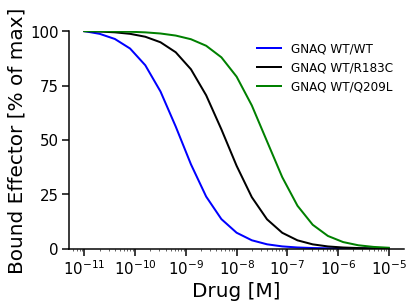

In [79]:
fig,ax = plt.subplots()
# plt.semilogx(FR_moles,(resp_list_WR4)*100/max(resp_list_WR4),'b',label='GNAQ WT/WT',linewidth=2,markersize=10)
# plt.semilogx(FR_moles,(resp_list_PR4)*100/max(resp_list_PR4),'k',color='black',label='GNAQ WT/R183C',linewidth=2,markersize=10)
# plt.semilogx(FR_moles,(resp_list_LR4)*100/max(resp_list_LR4),'g',label='GNAQ WT/Q209L',linewidth=2,markersize=10)
plt.semilogx(FR_moles,(resp_list_WR4)*100/max(resp_list_WR4),'b',label='GNAQ WT/WT',linewidth=2,markersize=10)
plt.semilogx(FR_moles,(resp_list_PR4)*100/max(resp_list_PR4),'k',color='black',label='GNAQ WT/R183C',linewidth=2,markersize=10)
plt.semilogx(FR_moles,(resp_list_LR4)*100/max(resp_list_LR4),'g',label='GNAQ WT/Q209L',linewidth=2,markersize=10)
#plt.plot([10**-12,FR_moles[-1]],[50,50],'--r',linewidth=2,markersize=10)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# increase tick width
ax.tick_params(length=7,width=1.5)
plt.xlabel('Drug [M]',size=20)
plt.ylabel('Bound Effector [% of max]',size=20)
plt.ylim([0,100])
plt.xticks(size=15)
plt.yticks([0,25,50,75,100],size=15)
plt.legend(loc='upper right',fontsize=12,frameon=False)
#plt.savefig('./FR_dose_response.svg',transparent='True')
#plt.savefig('./GNAQ_figures/reviewer_response_12-12-23/FR_dose_response.svg',dpi=200,transparent='True')